
# 심박수(HR)와 호흡수(BR)를 비접촉 레이더 데이터를 활용하여, 접촉(ECG) 데이터와 비교학습하여, 레이더 데이터만 가지고 심박수와 호흡수를 정확하게 예측하는 프로젝트

- *HR(심박, Heart Rate) 및 BR(호흡,Breathing Rate) 예측 모델링*
- *주어진 Radar 데이터에서 정확한 HR과 BR을 예측하기 위한 개인별, FFT크기별 데이터 분석 (DA)*
- *데이터를 활용한 ML/DL 모델 파이프라인 구축 프로젝트*  
(ensemble, svm 사용)

=====================================================    
ecg : 심장의 전기적 활동에 대한 기록인 심전도  
bpm : 분당 심장박동수

bin : 사물위치 (- 면 사물 앞, + 면 사물 뒤) 3.6cm 단위  
512fft : 512 frame window (512/20=25.6초 윈도우)의 FFT로 BPM 

=====================================================  
bin_var : 큰 움직임(3.6 cm)의 정도  
motion_energy : 작은 움직임(레이더 신호의 흔들림 크기)의 정도

# 1) 데이터 EDA / 시각화

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/와플 데이터"

11명의 사람의 데이터를 차례대로 df0 ~ df10로 지칭  
파일이름 : 날짜_사람이름_거리_자세_특이사항.csv

In [5]:
# 데이터 불러오기
drive = os.listdir(data_path) 

file_list = []

for i, file in enumerate(drive[:-2]):
  filename = os.path.join(data_path, file)
  file_list.append(filename)
  print(f'df{i} :', filename[36:])

df0 : log_20200909110309_chc_0.5_sit_none.csv
df1 : log_20201111155643_ksj_0.5_lie_none.csv
df2 : log_20210811104835_les_1.0_sleep.csv
df3 : log_20210812111825_sjy_1.0_lie_none.csv
df4 : log_20210818153244_kdu_1.0_lie_none.csv
df5 : log_20210824111504_kdu_1.0_lie_none.csv
df6 : log_20210824121025_chc_0.5_lie_none.csv
df7 : log_20210824141813_kdu_1.0_lie_acryl.csv
df8 : log_20210824141815_kdu_1.0_lie_opaque.csv
df9 : log_20210906175352_1.0_lie_gmk.csv
df10 : log_20210908142718_kdu_1.0_lie_acryl111.csv


In [6]:
data = {}
for i, j in enumerate(file_list):
  data[f"df{i}"] = pd.read_csv(j, index_col=0)

In [7]:
# ex) df0의 데이터
data['df0']

,ecg,bpm,bin-2,bin-1,bin0,bin1,bin2,512fft,400fft,300fft,200fft,100fft,70fft,bin_var,motion_energy
0,101.298701,86.953125,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
1,121.875000,86.989083,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
2,121.875000,87.025041,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
3,121.875000,87.061000,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
4,121.875000,87.096958,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,90.948144,89.765625,90.234375,89.0625,83.203125,90.234375,51.5625,83.203125,97.265625,82.031250,94.921875,92.578125,91.40625,0.0,1.158152
23996,90.948144,89.765625,90.234375,89.0625,83.203125,90.234375,51.5625,83.203125,97.265625,82.031250,94.921875,92.578125,91.40625,0.0,1.158152
23997,90.948144,89.765625,90.234375,89.0625,83.203125,90.234375,51.5625,83.203125,97.265625,82.617188,94.921875,92.578125,91.40625,0.0,1.158152
23998,90.948144,89.765625,90.234375,89.0625,83.203125,90.234375,51.5625,83.203125,97.851562,82.617188,94.921875,92.578125,91.40625,0.0,1.158152


## 타겟값인 **ecg** 의 그래프

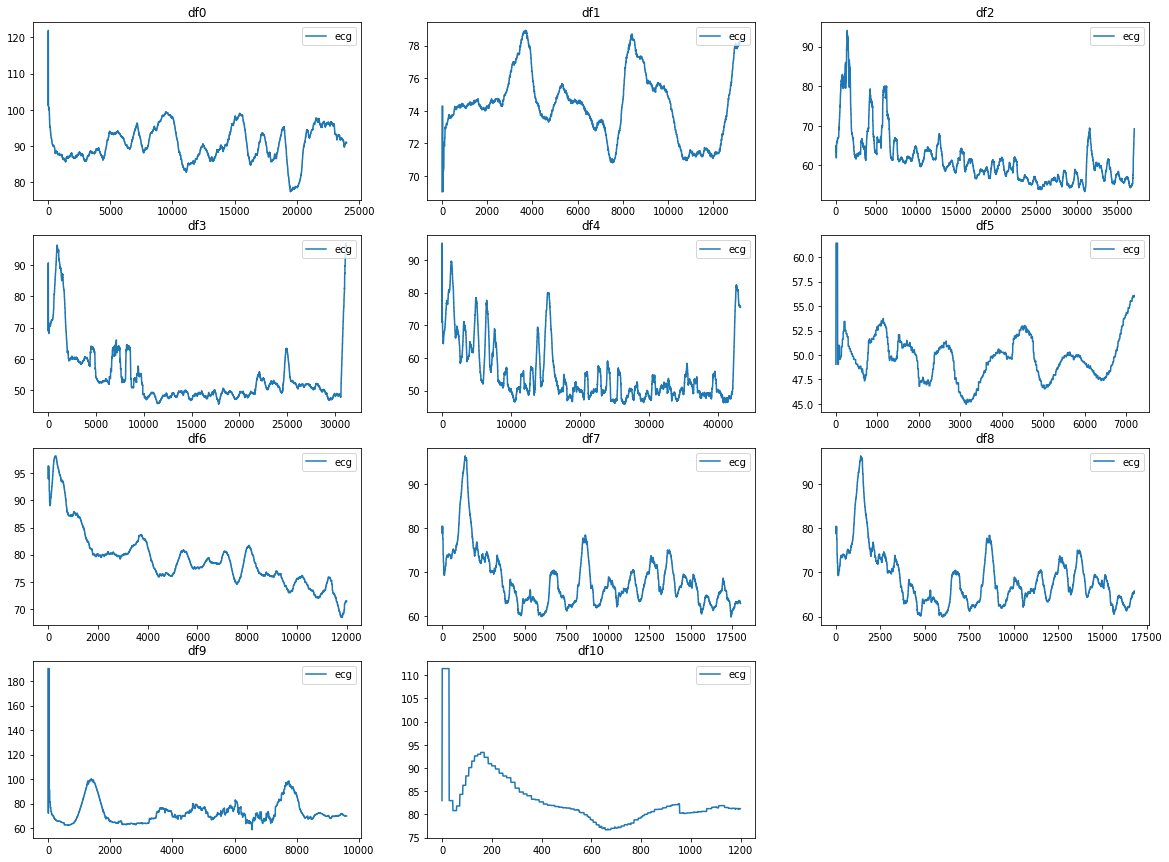

In [6]:
# ecg 그래프
plt.figure(figsize=(20, 15))
for i, j in enumerate(data):
  plt.subplot(4, 3, i+1)
  plt.title(j)
  plt.plot(data[j]['ecg'], label = 'ecg')
  plt.legend(loc='upper right')

plt.show()

ecg가 매우 높게 측정되는 경우가 있다  
ex) df0의 120, df9의 180, df10의 110

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


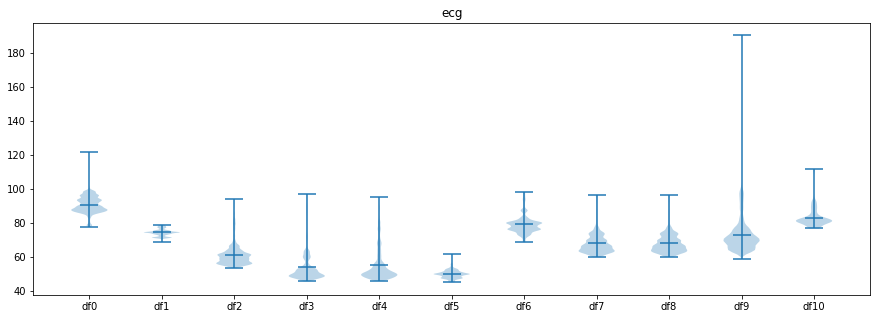

In [7]:
# 타겟인 ecg의 이상치
fig, ax = plt.subplots(figsize=(15, 5))
plt.title('ecg')
plt.violinplot([data[i]['ecg'] for i in data], showmeans=True)
ax.set_xticks(np.arange(1, 12))
ax.set_xticklabels(['df0', 'df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9', 'df10'])

plt.show()

※ 이상치가 실제 사람의 비정상적인 ecg인지  
단순히 측정 과정에서의 오류인지 구분하기 어렵기 때문에  
극단적으로 높게 측정된 이상치는 제거하지만  
이상치를 측정하는 것이 중요한 부분이다.


In [9]:
# 이상치 제거 함수(사분 범위)
def outlier(data):
  q1 = data.quantile(0.25)
  q3 = data.quantile(0.75)

  iqr = q3 - q1

  condition1 = (data < q3+3*iqr)
  condition2 = (data > q1-3*iqr)

  data = data[condition1 & condition2]
  
  return data

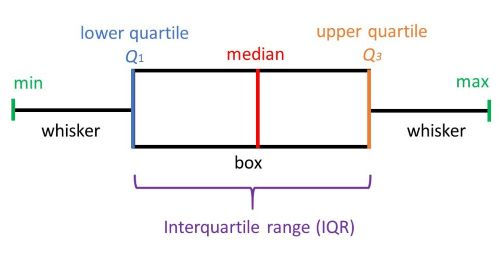

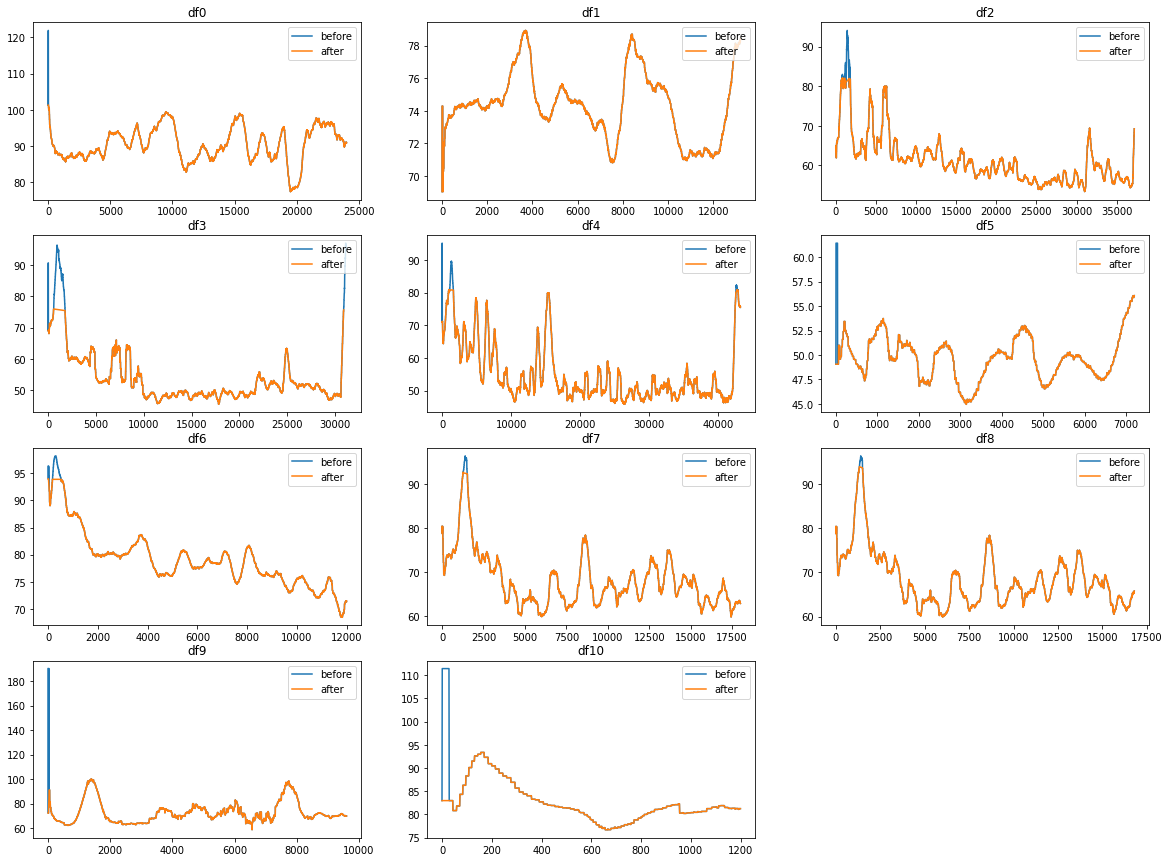

In [10]:
# 이상치 제거 후의 ecg 그래프
plt.figure(figsize=(20, 15))
for i, j in enumerate(data):
  plt.subplot(4, 3, i+1)
  plt.title(j)
  plt.plot(data[j]['ecg'], label = 'before')
  plt.plot(outlier(data[j]['ecg']), label = 'after')
  plt.legend(loc='upper right')

plt.show()

In [11]:
# 이상치 제거
for i in data:
  data[i] = data[i].loc[outlier(data[i]['ecg']).index]

## 개인별, fft 크기별 데이터 분석(타겟 : ecg)
ex) df0의 데이터

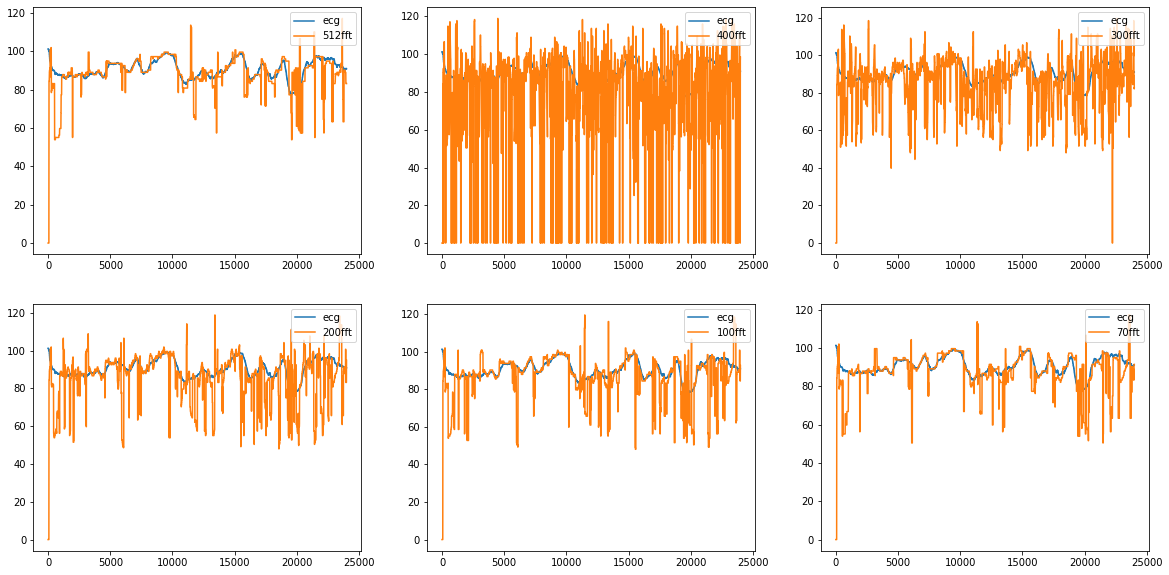

In [12]:
# df0의 ecg와 fft의 그래프
plt.figure(figsize=(20,10))
for i, j in enumerate(['512fft', '400fft',	'300fft',	'200fft',	'100fft',	'70fft']):
  plt.subplot(2, 3, i+1)
  plt.plot(data['df0']['ecg'],label='ecg')
  plt.plot(data['df0'][j], label=j)
  plt.legend(loc='upper right')

plt.show()

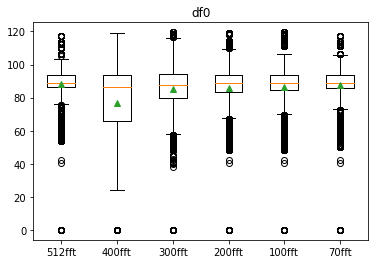

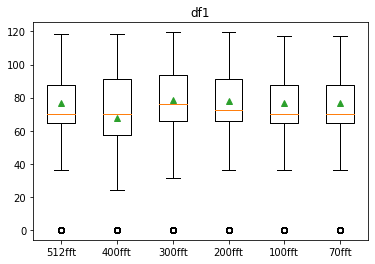

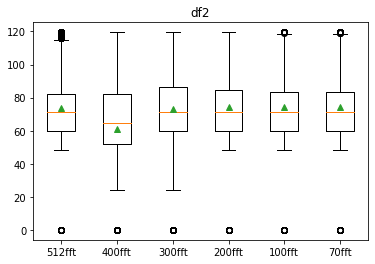

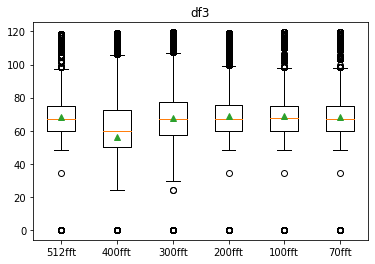

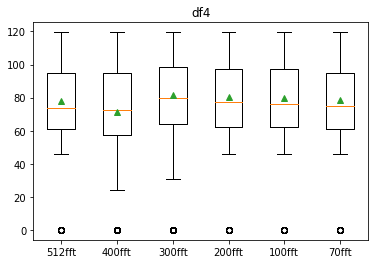

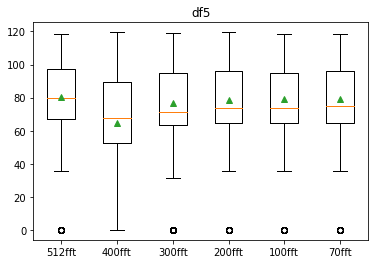

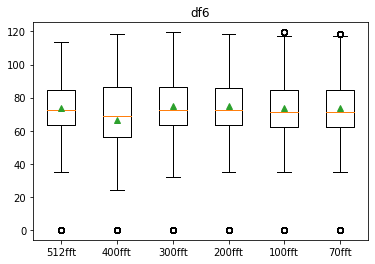

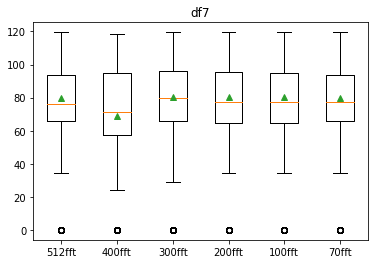

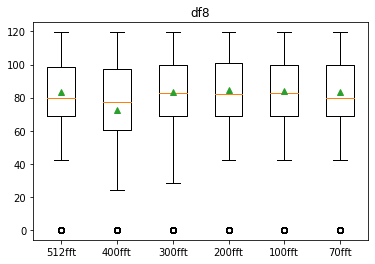

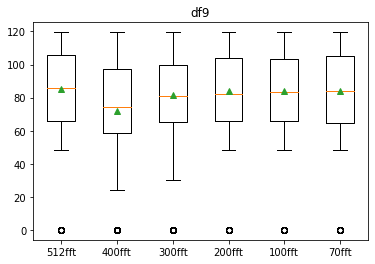

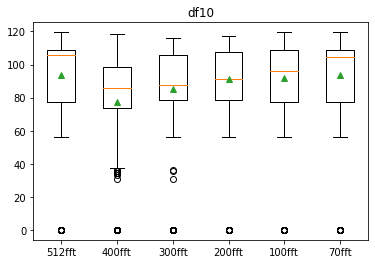

In [13]:
# 11명의 사람의 fft데이터의 이상치 그래프
for i, j in enumerate(data):
  fig, ax = plt.subplots()
  plt.title(j)
  plt.boxplot([data[j]['512fft'], data[j]['400fft'], data[j]['300fft'], data[j]['200fft'], data[j]['100fft'], data[j]['70fft']], showmeans=True)
  ax.set_xticks(np.arange(1, 7))
  ax.set_xticklabels(['512fft', '400fft', '300fft', '200fft', '100fft', '70fft'])

plt.show()

단순히 0으로 측정되는 부분을 이상치로 판단하여 모두 제거해버리면 데이터의 손실이 너무 크기 때문에  
6개 크기의 fft에서 모두 0으로 측정되는 부분은 측정과정에서의 오류로 판단되어 제거

In [12]:
for i in data:
  idx = data[i][(data[i]['512fft'] == 0) & (data[i]['400fft'] == 0) & (data[i]['300fft'] == 0) & (data[i]['200fft'] == 0) & (data[i]['100fft'] == 0) & ((data[i]['70fft'] == 0))].index
  data[i] = data[i].drop(idx)

## 개인별, bin 크기별 데이터 분석(타겟 : ecg)
ex) df1의 데이터

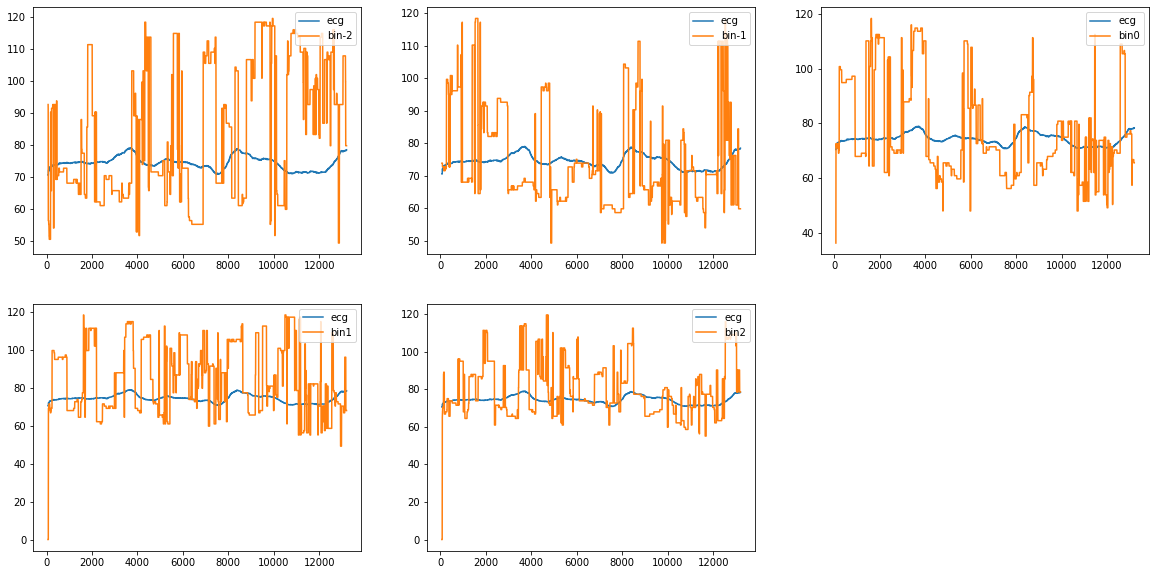

In [15]:
# ecg와 bin의 그래프
plt.figure(figsize=(20,10))
for i, j in enumerate(['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2']):
  plt.subplot(2, 3, i+1)
  plt.plot(data['df1']['ecg'],label='ecg')
  plt.plot(data['df1'][j], label=j)
  plt.legend(loc='upper right')

plt.show()

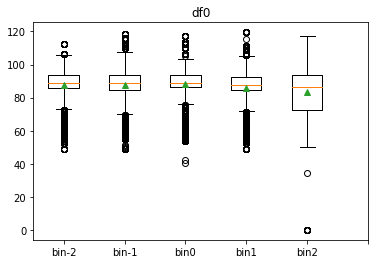

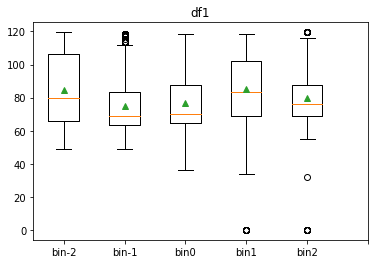

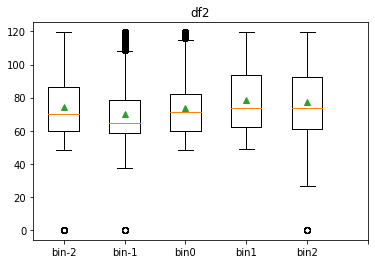

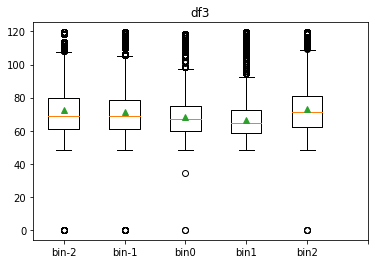

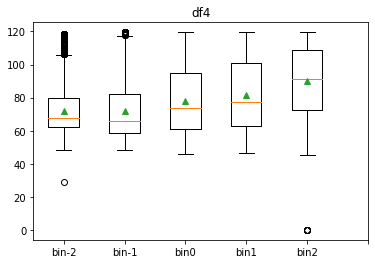

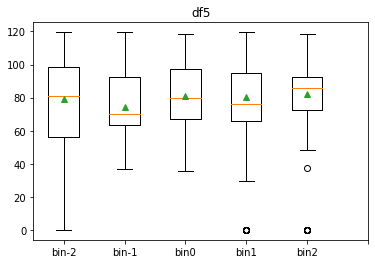

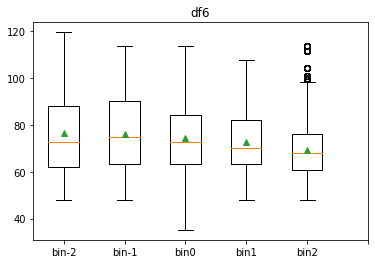

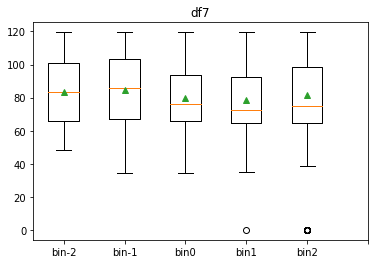

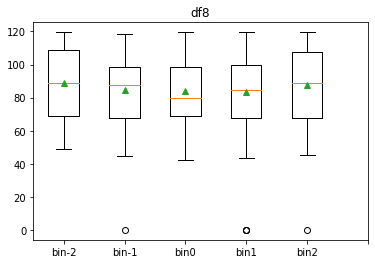

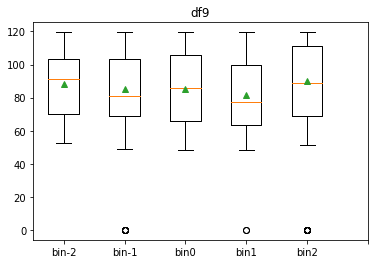

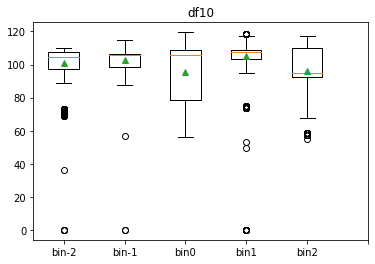

In [16]:
# 11명의 사람의 bin데이터의 이상치 그래프
for i, j in enumerate(data):
  fig, ax = plt.subplots()
  plt.title(j)
  plt.boxplot([data[j]['bin-2'], data[j]['bin-1'], data[j]['bin0'], data[j]['bin1'], data[j]['bin2']], showmeans=True)
  ax.set_xticks(np.arange(1, 7))
  ax.set_xticklabels(['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2'])

plt.show()

※ bin 특성에서는 대부분 시작하는 부분에서 0으로 측정되어서  
이 부분은 의미없다고 판단하여 제거

In [13]:
for i in data:
  idx = data[i][(data[i]['bin-2'] == 0) | (data[i]['bin-1'] == 0) | (data[i]['bin0'] == 0) | (data[i]['bin1'] == 0) | (data[i]['bin2'] == 0)].index
  data[i] = data[i].drop(idx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


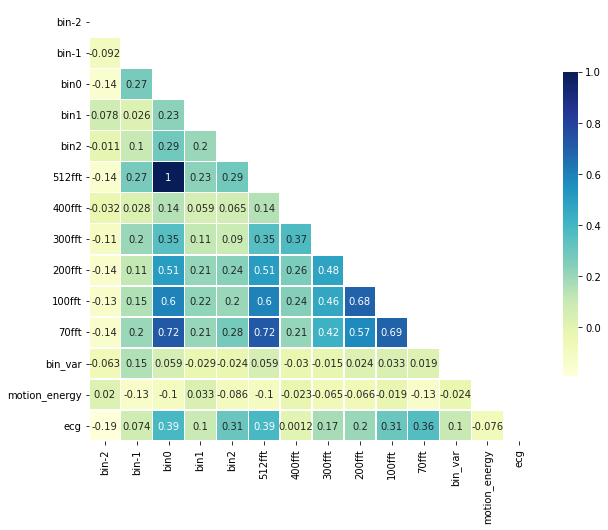

In [18]:
# 특성들의 히트맵
plt.figure(figsize=(10, 8))
features = ['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2', '512fft', '400fft', '300fft', '200fft', '100fft', '70fft', 'bin_var',	'motion_energy', 'ecg']

mask = np.zeros_like(data['df1'][features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data['df1'][features].corr(),annot=True, cmap='YlGnBu', linecolor = "white", mask=mask, linewidths=0.5, cbar_kws={"shrink": 0.7})
plt.show()

※ 가장 가까이에서 측정한 bin0과  
높은 프레임으로 측정한 512fft가  
타겟인 ecg와 강한 양적 상관관계를 가지고 있다.

예상외로 400fft가 프레임이 높은데도 불구하고 상관관계가 매우 낮다.

# 2) 성능 비교를 위한 기본 모델(NN)

<img src="https://ifh.cc/g/1gvv9V.png" width="400">

## 1. 개인 기본 모델(NN) 






In [14]:
import numpy as np
from numpy.random import seed
import tensorflow as tf
np.random.seed(2)
tf.random.set_seed(2)

In [15]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
     
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler

from sklearn.model_selection import train_test_split

In [21]:
def personal_model(n):
  X = data[n][['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2', '512fft', '400fft', '300fft', '200fft', '100fft', '70fft', 'bin_var', 'motion_energy']] 
  y = data[n][['ecg']]

  scaler_X = MinMaxScaler()
  scaler_y = MinMaxScaler()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
  
  # 훈련데이터
  scaler_X.fit(X_train)
  X_train = scaler_X.transform(X_train)
  scaler_y.fit(y_train)
  y_train = scaler_y.transform(y_train)
  # 테스트 데이터
  X_test = scaler_X.transform(X_test)
  y_test = scaler_y.transform(y_test)
  # 전체 데이터
  X_scale = scaler_X.fit_transform(X)

  # NN 기본모델
  model = Sequential()
  model.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

  model.fit(X_train, y_train, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
  
  # 테스트 데이터에 대한 MSE와 MAE
  eval = model.evaluate(X_test, y_test)
  print()
  print(f"test_MSE = {eval[1]:.3f}")        
  print(f"test_MAE = {eval[2]:.3f}")

  pred = model.predict(X_scale)
  pred = scaler_y.inverse_transform(pred)

  test = data[n]['ecg']
  pred = pred.reshape(-1)
  
  # 전체 데이터에 대한 예측 MAE
  print(f"total_MAE = {mean_absolute_error(test, pred):.3f}")

  # 전체 데이터 에러값
  df_e = pd.DataFrame(test)
  df_e['pred'] = pred
  df_e['Error_rate'] = 100 * (abs(df_e['ecg']-df_e['pred'])) / df_e['ecg']
  print(f"Error rate = {np.average(df_e['Error_rate']):.3f}%")

  # 전체 데이터 예측 그래프
  plt.figure(figsize=(12,6))
  plt.title(f'{n} Target & Predict')
  plt.plot(df_e['pred'], label = 'pred')
  plt.plot(df_e['ecg'], label = 'ecg')
  plt.legend(loc='upper right')
  plt.show()

ex) 11명중 df1의 데이터

Epoch 1/30
56/56 [==============================] - 1s 5ms/step - loss: 0.1617 - mse: 0.1617 - mae: 0.3291 - val_loss: 0.0511 - val_mse: 0.0511 - val_mae: 0.1871
Epoch 2/30
56/56 [==============================] - 0s 2ms/step - loss: 0.0505 - mse: 0.0505 - mae: 0.1864 - val_loss: 0.0484 - val_mse: 0.0484 - val_mae: 0.1825
Epoch 3/30
56/56 [==============================] - 0s 2ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1831 - val_loss: 0.0469 - val_mse: 0.0469 - val_mae: 0.1807
Epoch 4/30
56/56 [==============================] - 0s 2ms/step - loss: 0.0470 - mse: 0.0470 - mae: 0.1816 - val_loss: 0.0457 - val_mse: 0.0457 - val_mae: 0.1789
Epoch 5/30
56/56 [==============================] - 0s 2ms/step - loss: 0.0457 - mse: 0.0457 - mae: 0.1800 - val_loss: 0.0444 - val_mse: 0.0444 - val_mae: 0.1769
Epoch 6/30
56/56 [==============================] - 0s 2ms/step - loss: 0.0446 - mse: 0.0446 - mae: 0.1783 - val_loss: 0.0433 - val_mse: 0.0433 - val_mae: 0.1756
Epoch 7/30
56/56 [==========

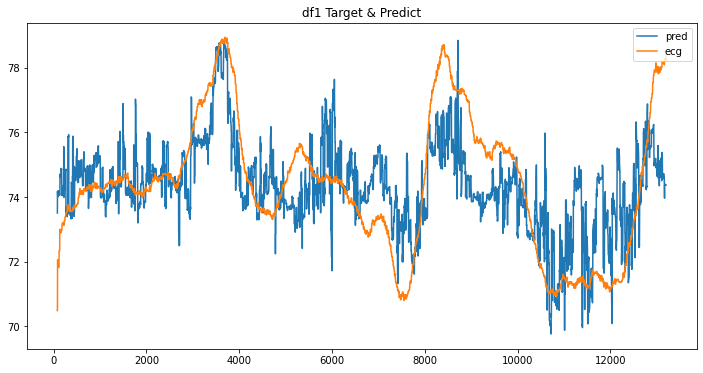

In [ ]:
personal_model('df1')

### df1에 대한 모델 개선

특성 제거
* 상관계수 히트맵에서 0.1미만의 특징 제거(bin-2, bin-1, 400fft, motion_energy)

전처리
* MinMaxScaler(base) : 최대/최소값이 각각 1, 0이 되도록 조정   
(그러나 이상치가 있다면 평균과 표준편차에 영향을 미쳐  
변환된 데이터의 확산은 매우 달라지게 된다)  

* PowerTransformer : 데이터의 특성별로 정규분포형태에 가깝도록 변환

모델
* NN모델에서 layer와 node수를 증가  
* batch size = 64



In [22]:
def personal_improved_model(n):
  # 히트맵에서 0.1이 안되는 특징 제거(bin-2, bin-1, 400fft, motion_energy)
  X = data[n][['bin0', 'bin1', 'bin2', '512fft', '300fft', '200fft', '100fft', '70fft', 'bin_var']] 
  y = data[n][['ecg']]

  # MinMaxScaler → PowerTransformer 사용 
  scaler_X = PowerTransformer()
  scaler_y = PowerTransformer()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
  
  # 훈련데이터
  scaler_X.fit(X_train)
  X_train = scaler_X.transform(X_train)
  scaler_y.fit(y_train)
  y_train = scaler_y.transform(y_train)
  # 테스트 데이터
  X_test = scaler_X.transform(X_test)
  y_test = scaler_y.transform(y_test)
  # 전체 데이터
  X_scale = scaler_X.fit_transform(X)

  # NN 기본모델에서 layer와 node수를 증가, batch_size=64
  model = Sequential()
  model.add(Dense(128, input_dim=9, kernel_initializer='normal', activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

  model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1, validation_split=0.2)
  
  # 테스트 데이터에 대한 MSE와 MAE
  eval = model.evaluate(X_test, y_test)
  print()
  print(f"test_MSE = {eval[1]:.3f}")        
  print(f"test_MAE = {eval[2]:.3f}")

  pred = model.predict(X_scale)
  pred = scaler_y.inverse_transform(pred)

  test = data[n]['ecg']
  pred = pred.reshape(-1)
  
  # 전체 데이터에 대한 예측 MAE
  print(f"total_MAE = {mean_absolute_error(test, pred):.3f}")

  # 전체 데이터 에러값
  df_e = pd.DataFrame(test)
  df_e['pred'] = pred
  df_e['Error_rate'] = 100 * (abs(df_e['ecg']-df_e['pred'])) / df_e['ecg']
  print(f"Error rate = {np.average(df_e['Error_rate']):.3f}%")

  # 전체 데이터 예측 그래프
  plt.figure(figsize=(12,6))
  plt.title(f'{n} Target & Predict')
  plt.plot(df_e['pred'], label = 'pred')
  plt.plot(df_e['ecg'], label = 'ecg')
  plt.legend(loc='upper right')
  plt.show()

Epoch 1/30
132/132 [==============================] - 2s 9ms/step - loss: 0.5612 - mse: 0.5612 - mae: 0.5938 - val_loss: 0.3565 - val_mse: 0.3565 - val_mae: 0.4477
Epoch 2/30
132/132 [==============================] - 1s 7ms/step - loss: 0.2996 - mse: 0.2996 - mae: 0.4026 - val_loss: 0.2014 - val_mse: 0.2014 - val_mae: 0.3373
Epoch 3/30
132/132 [==============================] - 1s 6ms/step - loss: 0.1838 - mse: 0.1838 - mae: 0.3070 - val_loss: 0.1371 - val_mse: 0.1371 - val_mae: 0.2600
Epoch 4/30
132/132 [==============================] - 1s 6ms/step - loss: 0.1328 - mse: 0.1328 - mae: 0.2534 - val_loss: 0.1531 - val_mse: 0.1531 - val_mae: 0.2616
Epoch 5/30
132/132 [==============================] - 1s 6ms/step - loss: 0.1079 - mse: 0.1079 - mae: 0.2240 - val_loss: 0.0938 - val_mse: 0.0938 - val_mae: 0.2084
Epoch 6/30
132/132 [==============================] - 1s 6ms/step - loss: 0.0825 - mse: 0.0825 - mae: 0.1919 - val_loss: 0.0732 - val_mse: 0.0732 - val_mae: 0.1765
Epoch 7/30
132/1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"


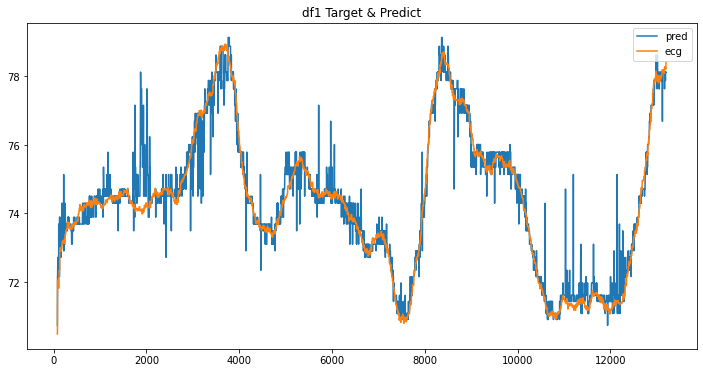

In [ ]:
personal_improved_model('df1')

* 기존 모델  
total_MAE = 1.168  
Error rate = 1.570%  

* 개선 모델  
total_MAE = 0.233  
Error rate = 0.312%  

## 2. 전체 데이터(df0~df10) 범용모델(base)

In [16]:
# 전체 합친 데이터
df = pd.concat([data[i] for i in data])

In [17]:
df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)

In [18]:
df.shape

(209033, 15)

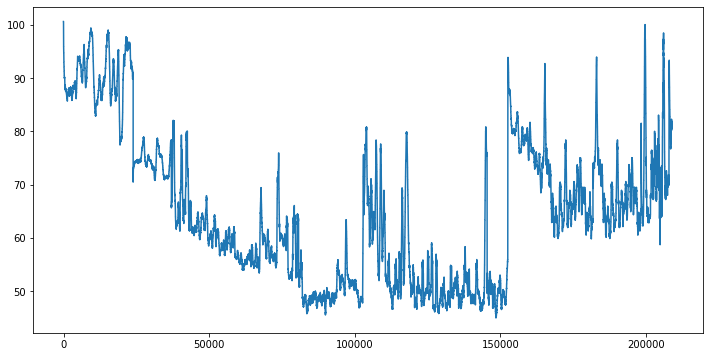

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df['ecg'])
plt.show()

In [20]:
X_total = df[['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2', '512fft', '400fft', '300fft', '200fft', '100fft', '70fft', 'bin_var', 'motion_energy']]
y_total = df[['ecg']]

In [21]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_total_train, X_total_test, y_total_train, y_total_test = train_test_split(X_total, y_total, test_size=0.2, random_state = 2)

# 훈련데이터
scaler_X.fit(X_total_train)
X_total_train = scaler_X.transform(X_total_train)

scaler_y.fit(y_total_train)
y_total_train = scaler_y.transform(y_total_train)

# 테스트 데이터
X_total_test = scaler_X.transform(X_total_test)
y_total_test = scaler_y.transform(y_total_test)

# 전체 데이터
X_scale = scaler_X.fit_transform(X_total)
y_scale = scaler_y.fit_transform(y_total)

In [30]:
# 전체 데이터 학습
model_T = Sequential()
model_T.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
model_T.add(Dense(30, activation='relu'))
model_T.add(Dense(1, activation='linear'))

model_T.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = model_T.fit(X_total_train, y_total_train, epochs=30, batch_size=150, verbose=1, validation_split=0.2)

Epoch 1/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0500 - mse: 0.0500 - mae: 0.1805 - val_loss: 0.0417 - val_mse: 0.0417 - val_mae: 0.1681
Epoch 2/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1625 - val_loss: 0.0379 - val_mse: 0.0379 - val_mae: 0.1582
Epoch 3/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1554 - val_loss: 0.0352 - val_mse: 0.0352 - val_mae: 0.1517
Epoch 4/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0347 - mse: 0.0347 - mae: 0.1492 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1467
Epoch 5/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0333 - mse: 0.0333 - mae: 0.1454 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1444
Epoch 6/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.1428 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1421
Epoch 7/30
892/8

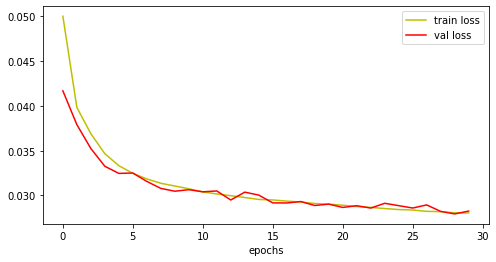

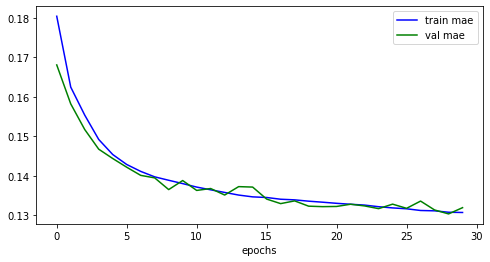

In [31]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],'y',label='train loss')
plt.plot(history.history['val_loss'],'r',label='val loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],'b',label='train mae')
plt.plot(history.history['val_mae'],'g',label='val mae')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [44]:
def graph(pred, test):
  # 그래프
  pred = pd.DataFrame(pred, columns=['pred'])
  test = pd.DataFrame(test, columns = ['target'])
  plt.figure(figsize=(20,6))
  plt.plot(pred, label='pred', alpha=0.5)
  plt.plot(test, label='ecg', alpha=0.5)
  plt.legend(loc='upper right')
  plt.show()

  # 분포 그래프
  D = pd.concat([pred, test], axis=1)
  plt.figure(figsize=(12,6))
  plt.hist([D['pred'], D['target']], bins=100, alpha=0.5, label=['pred', 'target'])
  plt.legend(loc='upper right')
  plt.show

In [33]:
# 테스트 데이터 예측 MAE
pred = model_T.predict(X_total_test)
pred = scaler_y.inverse_transform(pred)
test = scaler_y.inverse_transform(y_total_test)
pred = pred.reshape(-1)

# 테스트 데이터 예측 Error Rate
ER = pd.DataFrame(pred, columns=['pred'])
ER['ecg'] = test
ER['Error'] = (abs(ER['pred'] - ER['ecg']) / ER['ecg']) * 100

print(f"test_MAE = {mean_absolute_error(test, pred):.3f}")
print(f"Error rate = {np.average(ER['Error']):.3f}")

test_MAE = 7.385
Error rate = 11.916


In [34]:
# 전체(훈련 + 테스트) 데이터 예측
pred_T = model_T.predict(X_scale)
pred_T = scaler_y.inverse_transform(pred_T)
test_T = scaler_y.inverse_transform(y_scale)
pred_T = pred_T.reshape(-1)

# Error rate
ER = pd.DataFrame(pred_T, columns=['pred'])
ER['ecg'] = test_T
ER['Error'] = (abs(ER['pred'] - ER['ecg']) / ER['ecg']) * 100

print(f"MAE = {mean_absolute_error(test_T, pred_T):.3f}")
print(f"Error rate = {np.average(ER['Error']):.3f}")

MAE = 7.713
Error rate = 12.677


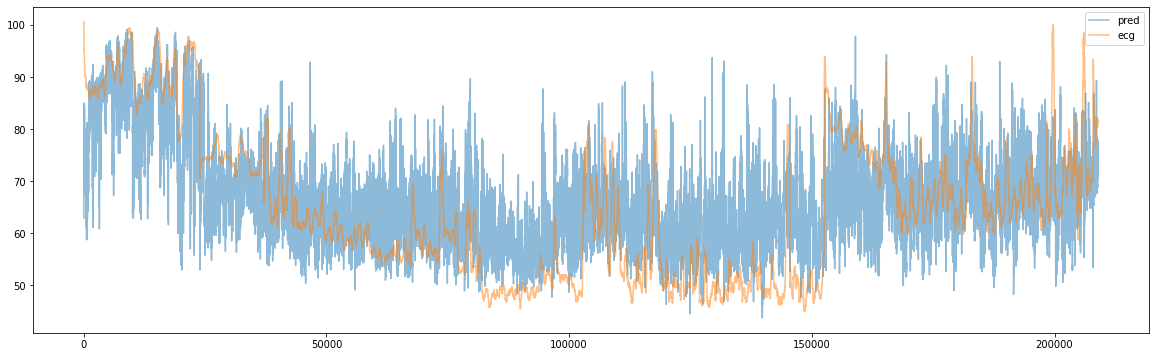

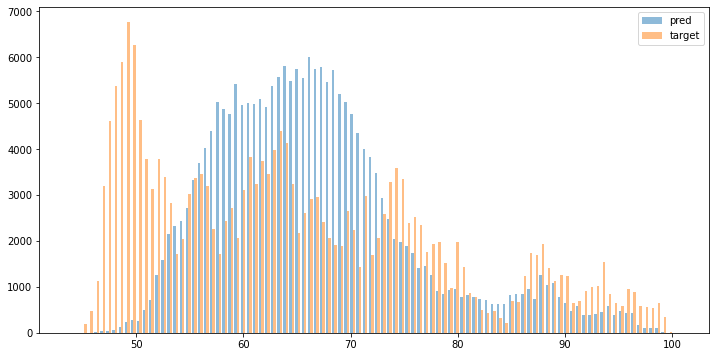

In [35]:
graph(pred_T, test_T)

※ 범용모델 baseline  
* 11명의 데이터에 대한 test데이터  
MAE = 7.385, Error rate = 11.916  

* 11명의 데이터에 대한 전체(train+test)데이터  
MAE = 7.713 Error rate = 12.677 



In [36]:
def general(df):
  X_total = df[['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2', '512fft', '400fft', '300fft', '200fft', '100fft', '70fft', 'bin_var', 'motion_energy']]
  y_total = df[['ecg']]

  scaler_X = MinMaxScaler()
  scaler_y = MinMaxScaler()

  # 전체 데이터
  X_scale = scaler_X.fit_transform(X_total)
  y_scale = scaler_y.fit_transform(y_total)

  # 전체데이터 예측
  pred_T = model_T.predict(X_scale)
  pred_T = scaler_y.inverse_transform(pred_T)
  test_T = scaler_y.inverse_transform(y_scale)
  pred_T = pred_T.reshape(-1)

  # Error rate
  ER = pd.DataFrame(pred_T, columns=['pred'])
  ER['ecg'] = test_T
  ER['Error'] = (abs(ER['pred'] - ER['ecg']) / ER['ecg']) * 100

  print(f"MAE = {mean_absolute_error(test_T, pred_T):.3f}")
  print(f"Error rate = {np.average(ER['Error']):.3f}")

In [37]:
# 범용모델에 대한 11명의 예측 평가지표(baseline)
for i in data:
  print(i)
  general(data[i])

df0
MAE = 3.303
Error rate = 3.658
df1
MAE = 1.749
Error rate = 2.334
df2
MAE = 4.939
Error rate = 8.160
df3
MAE = 4.343
Error rate = 8.189
df4
MAE = 6.796
Error rate = 12.252
df5
MAE = 2.282
Error rate = 4.563
df6
MAE = 3.866
Error rate = 4.899
df7
MAE = 6.021
Error rate = 9.104
df8
MAE = 6.638
Error rate = 9.939
df9
MAE = 7.381
Error rate = 10.176
df10
MAE = 4.903
Error rate = 6.000


## 전체 데이터(df0~df10)에 대한 PCA(주성분 분석)
특성이 많기 때문에 차원을 축소하기 위해 사용

In [22]:
from sklearn.decomposition import PCA
from sklearn import decomposition

In [ ]:
# 5개로 줄이기
pca = decomposition.PCA(n_components = 5)
pc = pca.fit_transform(X_scale)

pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# 타겟은 원래의 ecg
pc_df['Cluster'] = y_scale
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,Cluster
0,-0.156088,0.465974,-0.322282,-0.350060,0.590803,1.0
1,-0.096069,0.473402,-0.228448,-0.058154,0.532930,1.0
2,-0.096069,0.473402,-0.228448,-0.058154,0.532930,1.0
3,-0.096069,0.473402,-0.228448,-0.058154,0.532930,1.0
4,-0.082062,0.475058,-0.235199,-0.059867,0.535514,1.0


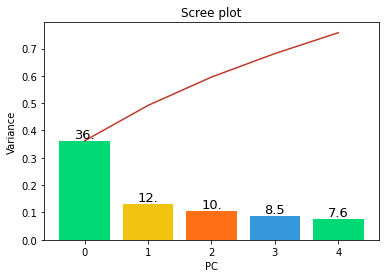

In [ ]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    ax = plt.subplot()
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals, color = ['#00da75', '#f1c40f',  '#ff6f15', '#3498db']) # Bar plot
    ax.plot(ind, cumvals, color = '#c0392b') # Line plot 
    
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va = "bottom", ha = "center", fontsize = 13)
     
    ax.set_xlabel("PC")
    ax.set_ylabel("Variance")
    plt.title('Scree plot')
    
scree_plot(pca)

In [ ]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.36232344 0.12951166 0.10371168 0.08596222 0.0763156 ]
0.7578245889037237


5개의 특성을 설정했을때 약 75%이므로  
PC1~PC5 5개로 설정

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
pc_X_train, pc_X_test, pc_y_train, pc_y_test = train_test_split(pc_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']], pc_df[['Cluster']], test_size=0.2, random_state = 2)

# 훈련데이터
scaler_X.fit(pc_X_train)
pc_X_train = scaler_X.transform(pc_X_train)

scaler_y.fit(pc_y_train)
pc_y_train = scaler_y.transform(pc_y_train)

# 테스트 데이터
pc_X_test = scaler_X.transform(pc_X_test)
pc_y_test = scaler_y.transform(pc_y_test)

In [ ]:
model_pc = Sequential()
model_pc.add(Dense(20, input_dim=5, kernel_initializer='normal', activation='relu'))
model_pc.add(Dense(30, activation='relu'))
model_pc.add(Dense(1, activation='linear'))

model_pc.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = model_pc.fit(pc_X_train, pc_y_train, epochs=30, batch_size=150, verbose=1, validation_split=0.2)

Epoch 1/30
892/892 [==============================] - 3s 2ms/step - loss: 0.0505 - mse: 0.0505 - mae: 0.1835 - val_loss: 0.0445 - val_mse: 0.0445 - val_mae: 0.1747
Epoch 2/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0434 - mse: 0.0434 - mae: 0.1715 - val_loss: 0.0419 - val_mse: 0.0419 - val_mae: 0.1686
Epoch 3/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1686 - val_loss: 0.0414 - val_mse: 0.0414 - val_mae: 0.1660
Epoch 4/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1658 - val_loss: 0.0406 - val_mse: 0.0406 - val_mae: 0.1654
Epoch 5/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0404 - mse: 0.0404 - mae: 0.1636 - val_loss: 0.0395 - val_mse: 0.0395 - val_mae: 0.1618
Epoch 6/30
892/892 [==============================] - 2s 2ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1617 - val_loss: 0.0393 - val_mse: 0.0393 - val_mae: 0.1615
Epoch 7/30
892/8

In [ ]:
pred_pc = model_pc.predict(pc_X_test)
pred_pc = pred_pc.reshape(-1)
pred_pc

array([0.32034257, 0.429263  , 0.29971987, ..., 0.27843955, 0.3083875 ,
       0.24757305], dtype=float32)

In [ ]:
pred_pc = model_pc.predict(pc_X_test)
pred_pc = pred_pc.reshape(-1,1)
pred_pc = scaler_y.inverse_transform(pred_pc)
test_pc = scaler_y.inverse_transform(pc_y_test)


# 테스트 데이터 예측 Error Rate
ER = pd.DataFrame(pred_pc, columns=['pred_pc'])
ER['ecg'] = test_pc
ER['Error'] = (abs(ER['pred_pc'] - ER['ecg']) / ER['ecg']) * 100

print(f"test_MAE = {mean_absolute_error(test_pc, pred_pc):.3f}")
print(f"Error rate = {np.average(ER['Error']):.3f}")

test_MAE = 0.155
Error rate = inf


타겟(ecg)을 0으로 측정하는 경우 에러율이 무한이 되는 경우 발생

In [ ]:
ER[ER['ecg']==0]

,pred_pc,ecg,Error
40926,0.233408,0.0,inf


In [ ]:
ER = ER.drop(40926)

In [ ]:
ER['Error'].mean()

108.18165284948631

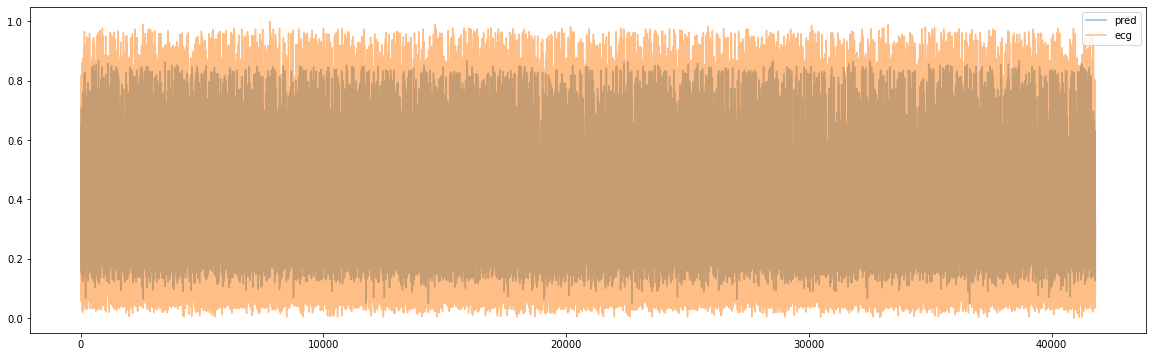

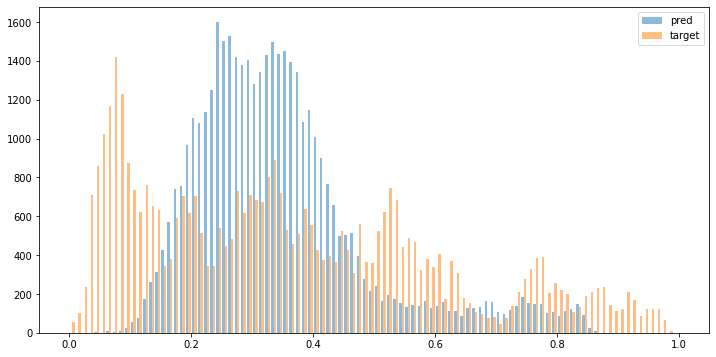

In [ ]:
graph(pred_pc, test_pc)

Error rate = 115.26  
차원을 축소하는 과정에서 데이터 손실이 많아서  
에러율이 높은 것으로 생각된다.

# 3) 전체 데이터(df0~df10) 범용 모델 성능 향상


## 주어진 Stacking Ensemble 방법
데이터를 같은 모델로 5번 훈련하여 5개의 결과를 내고  
5개의 결과를 합쳐서 다시 예측  
ex) 똑같은 NN모델로 5번 훈련 → 5개의 예측값 → 합쳐서 다시 예측

In [ ]:
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical 
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [ ]:
def fit_model(trainX, trainy):
	
    # define model
    model = Sequential()
    model.add(Dense(256, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
	
    # fit model
    model.fit(trainX, trainy, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
 
    return model

In [ ]:
makedirs('models')

In [ ]:
# fit and save models
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(X_total_train, y_total_train)
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

Epoch 1/30
892/892 [==============================] - 12s 12ms/step - loss: 0.0392 - mse: 0.0392 - mae: 0.1592 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1444
Epoch 2/30
892/892 [==============================] - 9s 11ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1382 - val_loss: 0.0298 - val_mse: 0.0298 - val_mae: 0.1372
Epoch 3/30
892/892 [==============================] - 7s 8ms/step - loss: 0.0273 - mse: 0.0273 - mae: 0.1287 - val_loss: 0.0284 - val_mse: 0.0284 - val_mae: 0.1303
Epoch 4/30
892/892 [==============================] - 8s 9ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.1205 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1221
Epoch 5/30
892/892 [==============================] - 7s 8ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1126 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.1116
Epoch 6/30
892/892 [==============================] - 7s 7ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.1051 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1025
Epoch 7/30
89

In [ ]:
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [ ]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


In [ ]:
from numpy import dstack

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX)
		yhat = yhat.reshape(yhat.shape[0], 1)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))

	return stackX

In [ ]:
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model 
	
	model = Sequential()
	model.add(Dense(256, input_dim=5, kernel_initializer='normal', activation='relu'))
	model.add(Dense(512, activation='relu'))
	model.add(Dense(1, activation='linear'))
	model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
	
  # fit model
	model.fit(stackedX, inputy, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
	#model.fit(stackedX, inputy)
	return model

In [ ]:
model = fit_stacked_model(members, X_total_train, y_total_train)

Epoch 1/30
892/892 [==============================] - 9s 10ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0363 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0389
Epoch 2/30
892/892 [==============================] - 12s 14ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0342 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0385
Epoch 3/30
892/892 [==============================] - 11s 13ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0344 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0385
Epoch 4/30
892/892 [==============================] - 11s 13ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0341 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0392
Epoch 5/30
892/892 [==============================] - 10s 11ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0345 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0383
Epoch 6/30
892/892 [==============================] - 8s 9ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0342 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0391
Epoch 7

In [ ]:
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [ ]:
yhat = stacked_prediction(members, model, X_total_test)
predictions = scaler_y.inverse_transform(yhat)

btest = scaler_y.inverse_transform(y_total_test)
bpred = predictions.reshape(-1)
mae = mean_absolute_error(btest, bpred)
print('Stacked Test MAE: %.3f' % mae)

Stacked Test MAE: 2.126


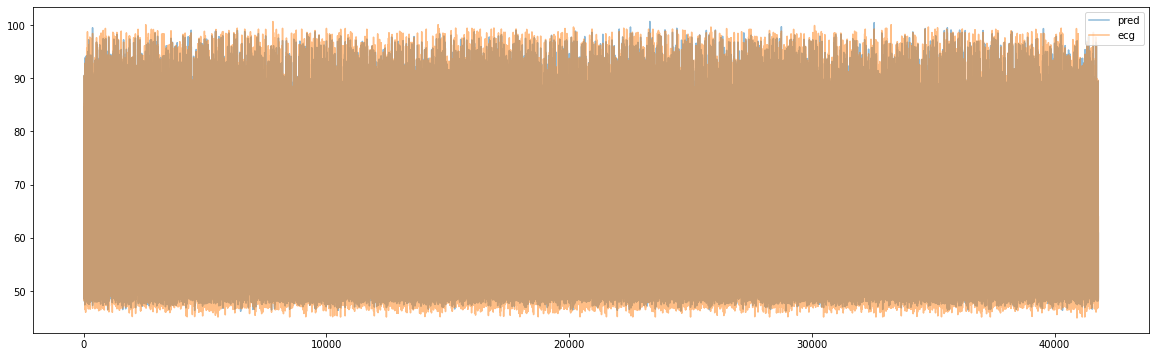

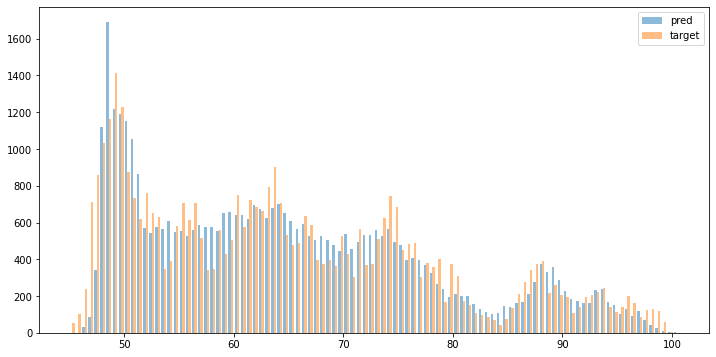

In [ ]:
graph(bpred, btest)

In [ ]:
yhat = stacked_prediction(members, model, X_scale)
predictions = scaler_y.inverse_transform(yhat)

btest = scaler_y.inverse_transform(y_scale)
bpred = predictions.reshape(-1)
mae = mean_absolute_error(btest, bpred)
print('Stacked Test MAE: %.3f' % mae)

Stacked Test MAE: 4.688


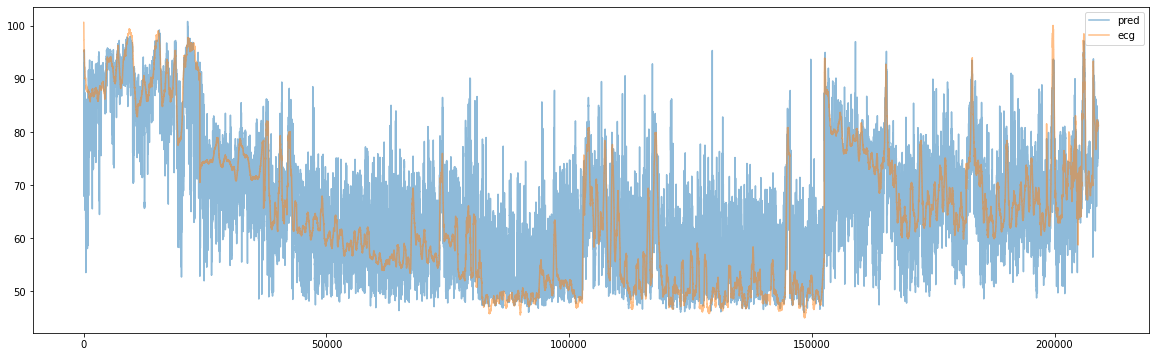

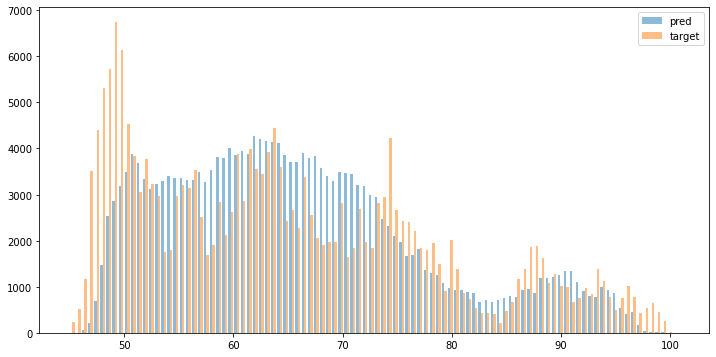

In [ ]:
graph(bpred, btest)

## CV KFold 스태킹 앙상블
(기존의 앙상블 방법은 과적합의 위험이 큼)

### CV Stacking Ensemble Model
* 원본 데이터의 train, test가 존재
* 원본 train data를 여러개의 모델로 학습
* 각 모델마다 test데이터를 넣어서 예측 후 predict을 뽑아냄
* 여러개의 predict 데이터를 다시 train 데이터로 사용
* 최종 모델을 하나 선정하여 학습
* 최종 평가  

==========================================================
* NN, SVM, RandomForestRegression, XGBoost, LGBM 5개의 모델로 각각 학습
* 전처리 및 하이퍼파라미터 조정 후 가장 성능이 좋은 모델을 최종모델로 하여 학습


In [23]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import pickle
import joblib

In [24]:
# 모델1 = NN(은닉층의 노드 수 증가, layer 추가, 활성화 함수 leaky relu)
model1 = Sequential()
model1.add(Dense(256, input_dim=13, kernel_initializer='normal', activation='relu'))
model1.add(Dense(512, activation='leaky_relu'))
model1.add(Dense(512, activation='leaky_relu'))
model1.add(Dense(1, activation='linear'))

model1.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

model1.fit(X_total_train, y_total_train, epochs=30, batch_size=100, verbose=1, validation_split=0.2)

Epoch 1/30
1338/1338 [==============================] - 16s 12ms/step - loss: 0.0363 - mse: 0.0363 - mae: 0.1515 - val_loss: 0.0304 - val_mse: 0.0304 - val_mae: 0.1386
Epoch 2/30
1338/1338 [==============================] - 15s 11ms/step - loss: 0.0286 - mse: 0.0286 - mae: 0.1317 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1264
Epoch 3/30
1338/1338 [==============================] - 15s 11ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1234 - val_loss: 0.0243 - val_mse: 0.0243 - val_mae: 0.1202
Epoch 4/30
1338/1338 [==============================] - 15s 11ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1147 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.1120
Epoch 5/30
1338/1338 [==============================] - 15s 11ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1067 - val_loss: 0.0192 - val_mse: 0.0192 - val_mae: 0.1046
Epoch 6/30
1338/1338 [==============================] - 15s 11ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0995 - val_loss: 0.0158 - val_mse: 0.0158 - val_mae:

In [25]:
# 모델2 = SVM
model2 = SVR(kernel='linear', C = 1.0, epsilon = 0.1, gamma = 'auto')
model2.fit(X_total_train, y_total_train)

# kernel : 선형 커널
# C : 학습 오류에 대한 패널티, C 값이 클 수록 모델이 학습 데이터에 좀 더 최적화 됨, 너무 크면 오버피팅 발생
# Epsilon : 임계값, 예측한 값이 GT 범위 안에 있으면 패널티 부여 X

joblib.dump(model2, '/content/drive/MyDrive/와플 데이터/SVRmodel.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['/content/drive/MyDrive/와플 데이터/SVRmodel.pkl']

In [26]:
# 저장한 SVR모델 불러오기
model2 = joblib.load('/content/drive/MyDrive/와플 데이터/SVRmodel.pkl')

In [27]:
# 모델3 = 랜덤포레스트
model3 = RandomForestRegressor(n_estimators = 200, max_depth = 25, random_state=2)
model3.fit(X_total_train, y_total_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(max_depth=25, n_estimators=200, random_state=2)

In [28]:
# 모델4 = XGB
model4 = xgb.XGBRegressor(n_estimators = 200, max_depth = 25, random_state=2)
model4.fit(X_total_train, y_total_train)

[06:42:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=25, n_estimators=200, random_state=2)

In [29]:
# 모델5 = LGBM
model5 = LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=25, random_state=2)
model5.fit(X_total_train, y_total_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(learning_rate=0.05, max_depth=25, n_estimators=1000,
              random_state=2)

In [30]:
def evaluation(model):
  pred = model.predict(X_total_test)
  pred = pred.reshape(-1, 1)
  pred = scaler_y.inverse_transform(pred)

  test = scaler_y.inverse_transform(y_total_test)

  mse = mean_squared_error(test, pred)
  mae = mean_absolute_error(test, pred)

  ER = pd.DataFrame(pred, columns=['pred'])
  ER['ecg'] = test
  ER['Error'] = (abs(ER['pred'] - ER['ecg']) / ER['ecg']) * 100
  er = np.average(ER['Error'])
  
  print("MSE =", mse)
  print("MAE =", mae)
  print("Error Rate =", er)

In [31]:
# 5개 모델에 대한 테스트데이터 평가지표
print("NN model")
evaluation(model1)
print()
print("SVR model")    # 성능이 가장 안좋음
evaluation(model2)
print()
print("RFR model")
evaluation(model3)
print()
print("XGB model")
evaluation(model4)
print()
print("LGBM model")
evaluation(model5)

NN model
MSE = 13.881653801505365
MAE = 2.6161652261419763
Error Rate = 4.092408651083923

SVR model
MSE = 147.03260296106242
MAE = 9.743833820369945
Error Rate = 14.877751131634467

RFR model
MSE = 1.7748678817960426
MAE = 0.3875374657078115
Error Rate = 0.6195746426190218

XGB model
MSE = 2.213963814749148
MAE = 0.2810961086979028
Error Rate = 0.45147157305587765

LGBM model
MSE = 16.411508156805738
MAE = 2.944476245257953
Error Rate = 4.695646686136361


||NN|SVR|RFR|XGB|LGBM|
|--|--|--|--|--|--|
|test_MSE|13.881|147.032|1.774|2.213|16.411|
|test_MAE|2.616|9.743|0.387|0.281|2.944|
|Error Rate|4.092|14.877|0.619|0.451|4.695|

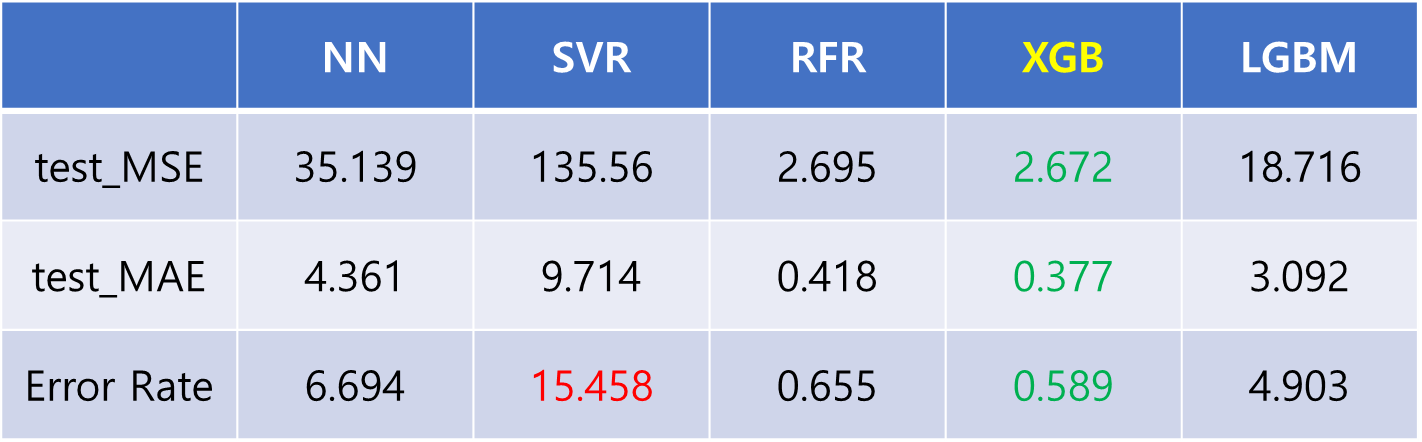

### 5개중 3개의 모델 RandomForest, XGBoost, LGBM 모델의 특성중요도

In [32]:
def get_top_features(model):
    features = ['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2', '512fft', '400fft', '300fft', '200fft', '100fft', '70fft', 'bin_var', 'motion_energy']
    ftr_importances_values = model.feature_importances_ 
    ftr_importances = pd.Series(ftr_importances_values, index=features)
    ftr_top = ftr_importances.sort_values(ascending=False)
    return ftr_top

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(20,10),nrows=1, ncols=3)
    fig.tight_layout() 
    model_name = ['RFR', 'XGB', 'LGBM']
    for i, model in enumerate(models):
        ftr_top = get_top_features(model)
        axs[i].set_title(f'{model_name[i]} Feature Importances', size=25)
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(20)
        sns.barplot(x=ftr_top.values, y=ftr_top.index , ax=axs[i])

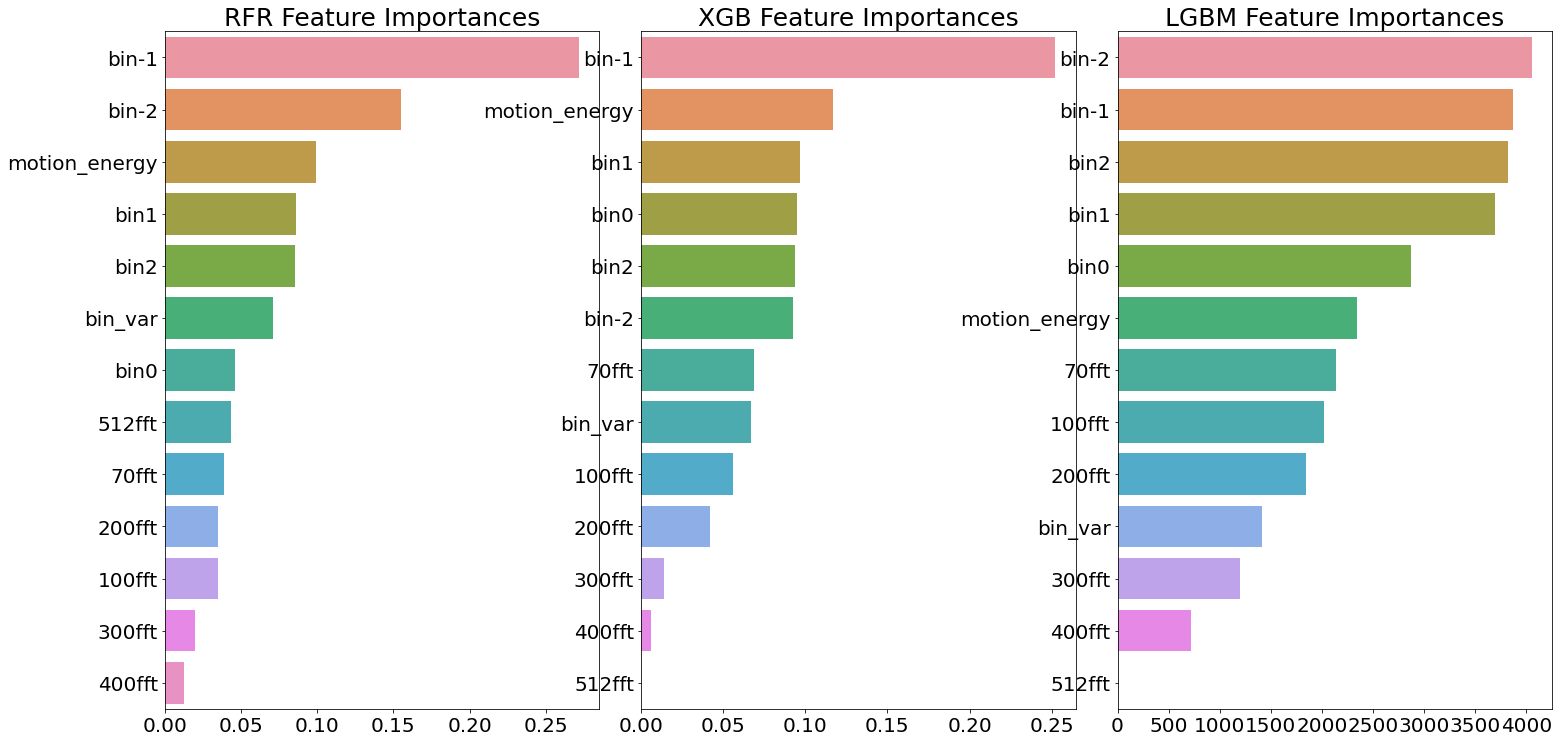

In [33]:
visualize_ftr_importances([model3, model4, model5])



* 특성제거
특성 중요도 그래프에서 중요도가 낮은 특성들 제거
* 5가지 모델중 성능이 가장 안좋은 모델인 SVR모델을 빼고 4가지 모델로 스태킹 진행

In [34]:
# 특성중요도에서 하위 3개중 중복되는 것이 400fft와 300fft이므로 제거하고 모델링
X_final = df[['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2', '512fft', '200fft', '100fft', '70fft', 'bin_var', 'motion_energy']]
y_final = df[['ecg']]

In [35]:
# PowerTransformer 사용
scaler_X = PowerTransformer()
scaler_y = PowerTransformer()

X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_final, y_final, test_size=0.2, random_state = 2)

# 훈련데이터
scaler_X.fit(X_final_train)
X_final_train = scaler_X.transform(X_final_train)

scaler_y.fit(y_final_train)
y_final_train = scaler_y.transform(y_final_train)

# 테스트 데이터
X_final_test = scaler_X.transform(X_final_test)
y_final_test = scaler_y.transform(y_final_test)

# 전체 데이터
X_final_scaled = scaler_X.fit_transform(X_final)
y_final_scaled = scaler_y.fit_transform(y_final)

과적합 방지를 위한 Cross Validation  

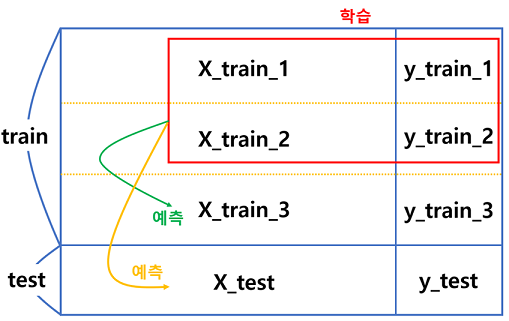

In [36]:
from sklearn.model_selection import KFold

# 메타 모델을 위한 학습 및 테스트 데이터 만들기
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=11)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat
        test_pred[:, folder_counter] = model.predict(X_test_n).reshape(-1) # y_test 예측, 폴드 끝나면 평균
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

In [40]:
# 4가지 모델(SVR의 평가지표가 안좋아서 빼고 4가지 모델로 진행)
model1 = Sequential()
model1.add(Dense(256, input_dim=11, kernel_initializer='normal', activation='relu'))
model1.add(Dense(512, activation='leaky_relu'))
model1.add(Dense(512, activation='leaky_relu'))
model1.add(Dense(1, activation='linear'))
model1.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

model2 = RandomForestRegressor(n_estimators = 200, max_depth = 25, random_state=2)

model3 = xgb.XGBRegressor(n_estimators = 200, max_depth=25, random_state=2)

model4 = LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=25, random_state=2)

# 최종모델
lr_final = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=25)

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기
NN_train, NN_test = get_stacking_base_datasets(model1, X_final_train, y_final_train, X_final_test, 7)
RFR_train, RFR_test = get_stacking_base_datasets(model2, X_final_train, y_final_train, X_final_test, 7)
XGB_train, XGB_test = get_stacking_base_datasets(model3, X_final_train, y_final_train, X_final_test, 7)
LGBM_train, LGBM_test = get_stacking_base_datasets(model4, X_final_train, y_final_train, X_final_test, 7)

# 개별 모델로부터 나온 y_final_train 예측값들 옆으로 붙이기
Stack_X_final_train = np.concatenate((NN_train, RFR_train, XGB_train, LGBM_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_X_final_test = np.concatenate((NN_test, RFR_test, XGB_test, LGBM_test), axis=1)

폴드 세트 :  0  시작
4480/4480 [==============================] - 31s 7ms/step - loss: 0.5052 - mse: 0.5052 - mae: 0.5608
폴드 세트 :  1  시작
4480/4480 [==============================] - 31s 7ms/step - loss: 0.3864 - mse: 0.3864 - mae: 0.4751
폴드 세트 :  2  시작
4480/4480 [==============================] - 30s 7ms/step - loss: 0.3044 - mse: 0.3044 - mae: 0.4153
폴드 세트 :  3  시작
4480/4480 [==============================] - 29s 6ms/step - loss: 0.2472 - mse: 0.2472 - mae: 0.3701
폴드 세트 :  4  시작
4480/4480 [==============================] - 30s 7ms/step - loss: 0.2055 - mse: 0.2055 - mae: 0.3349
폴드 세트 :  5  시작
4480/4480 [==============================] - 29s 6ms/step - loss: 0.1803 - mse: 0.1803 - mae: 0.3121
폴드 세트 :  6  시작
4480/4480 [==============================] - 29s 7ms/step - loss: 0.1583 - mse: 0.1583 - mae: 0.2912
폴드 세트 :  0  시작


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


폴드 세트 :  1  시작


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


폴드 세트 :  2  시작


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


폴드 세트 :  3  시작


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


폴드 세트 :  4  시작


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


폴드 세트 :  5  시작


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


폴드 세트 :  6  시작


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


폴드 세트 :  0  시작
[07:16:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트 :  1  시작
[07:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트 :  2  시작
[07:21:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트 :  3  시작
[07:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트 :  4  시작
[07:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트 :  5  시작
[07:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트 :  6  시작
[07:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
폴드 세트 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


폴드 세트 :  1  시작


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


폴드 세트 :  2  시작


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


폴드 세트 :  3  시작


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


폴드 세트 :  4  시작


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


폴드 세트 :  5  시작


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


폴드 세트 :  6  시작


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## ※베이지안 최적화(이번 모델에 사용하지 않음)

In [ ]:
"""
!pip install Bayesian-Optimization
from bayes_opt import BayesianOptimization
def XGB_cv(max_depth,learning_rate, n_estimators, gamma
             ,min_child_weight, subsample
             ,colsample_bytree, silent=True, nthread=-1):

      # 모델 정의
      model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree, 
                                nthread=nthread
                                )
      # 모델 훈련
      model.fit(X_total_train, y_total_train)

      # 예측값 출력
      y_pred= model.predict(X_total_test)

      # 각종 metric 계산
      mae = mean_absolute_error(y_total_test, y_pred)
      r2 = r2_score(y_total_test, y_pred)

      # 오차 최적화로 사용할 metric 반환
      return mae

pbounds = {'max_depth': (10, 30),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (5000, 10000),
                'gamma': (0, 100),
                'min_child_weight': (0, 3),
                'subsample': (0.5, 1),
                'colsample_bytree' :(0.2, 1)
                }

  # Bayesian optimization 객체 생성
  # f : 탐색 대상 함수, pbounds : hyperparameter 집합
  # verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
  # random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1)    

  # 메소드를 이용해 최대화 과정 수행
  # init_points : 초기 Random Search 갯수
  # n_iter : 반복 횟수 (많을 수록 정확한 값을 얻을 수 있다.)
  # acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
  # xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

  # ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타낸다
  # 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우 
  # bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시한다

# 찾은 파라미터 값 확인
print(bo.max)
"""

## hyperopt 최적화(XGB는 하이퍼파라미터에 예민함)

In [ ]:
!pip install hyperopt

In [ ]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]

# space 정의, Hyperparameter의 이름을 key 값으로 입력(최소값, 최대값, 간격)
space={'max_depth': hp.quniform("max_depth", 5, 50, 1),
       'learning_rate': hp.quniform ('learning_rate', 0.01, 0.05, 0.005),
       'reg_alpha' : hp.choice('reg_alpha', reg_candidate),
       'reg_lambda' : hp.choice('reg_lambda', reg_candidate),
       'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
       'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.05),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 200, 1500, 100)
      }

# 목적 함수 정의
# n_estimators, max_depth와 같은 반드시 int 타입을 가져야 하는 hyperparamter는 int로 변환
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), 
                       max_depth = int(space['max_depth']), 
                       learning_rate = space['learning_rate'],
                       reg_alpha = space['reg_alpha'],
                       reg_lambda = space['reg_lambda'],
                       subsample = space['subsample'],
                       colsample_bytree = space['colsample_bytree'], 
                       min_child_weight = int(space['min_child_weight']),
                       random_state=2, 
                      )
    
    evaluation = [(Stack_X_final_train, y_final_train), (Stack_X_final_test, y_final_test)]
    
    model.fit(Stack_X_final_train, y_final_train,
              eval_set=evaluation, 
              eval_metric="mae",
              early_stopping_rounds=20,
              verbose=0)

    pred = model.predict(Stack_X_final_test)
    mae= mean_absolute_error(y_final_test, pred)    
    # 평가 방식 선정
    return {'loss':mae, 'status': STATUS_OK, 'model': model}

In [ ]:
trials = Trials()
# best에 최적의 하이퍼 파라미터를 return
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30, # 최대 반복 횟수 지정
            trials=trials)

# 최적화된 결과를 int로 변환해야하는 파라미터 타입 변환
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
best['n_estimators'] = int(best['n_estimators'])
best['reg_alpha'] = reg_candidate[int(best['reg_alpha'])]
best['reg_lambda'] = reg_candidate[int(best['reg_lambda'])]
#best['random_state'] = SEED
print (best)

[09:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:43:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:45:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
best_model = xgb.XGBRegressor(**best)
best_model.fit(Stack_X_final_train, y_final_train)

joblib.dump(best_model, '/content/drive/MyDrive/와플 데이터/Final_model.pkl')

[11:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


['/content/drive/MyDrive/와플 데이터/Final_model.pkl']

In [41]:
best_model = joblib.load('/content/drive/MyDrive/와플 데이터/Final_model.pkl')

[07:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [42]:
pred_s = best_model.predict(Stack_X_final_test)
pred_s = pred_s.reshape(-1, 1)
pred_s = scaler_y.inverse_transform(pred_s)

test_s = scaler_y.inverse_transform(y_final_test)

mse = mean_squared_error(test_s, pred_s)
mae = mean_absolute_error(test_s, pred_s)

ER = pd.DataFrame(pred_s, columns=['pred_s'])
ER['ecg'] = test_s
ER['Error'] = (abs(ER['pred_s'] - ER['ecg']) / ER['ecg']) * 100
er = np.average(ER['Error'])
print("MSE =", mse)
print("MAE =", mae)
print("Error Rate =", er)

MSE = 1.5027885515242267
MAE = 0.32594487570744385
Error Rate = 0.5013920067619563


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"


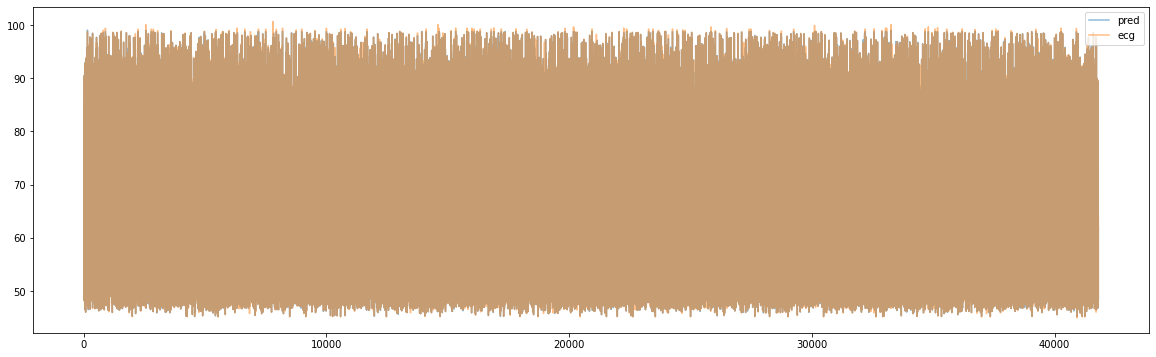

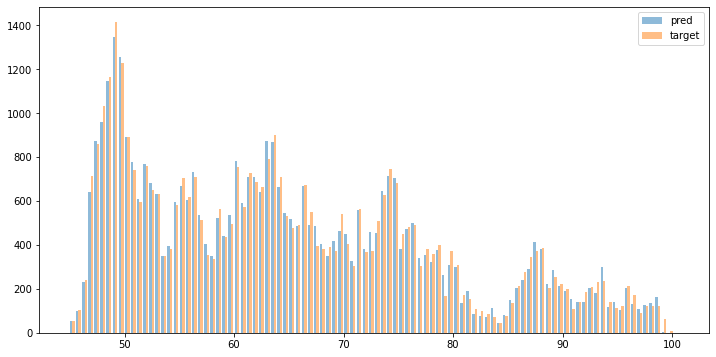

In [45]:
graph(pred_s, test_s)

## 최종모델 개인별 확인

In [54]:
def final_get_stacking_base_datasets(model, X_train_n, y_train_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=11)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) 
        
    return train_fold_pred

In [75]:
def stacking_model(n):
  X_final = data[n][['bin-2', 'bin-1', 'bin0', 'bin1', 'bin2', '512fft', '200fft', '100fft', '70fft', 'bin_var', 'motion_energy']]
  y_final = data[n][['ecg']]

  # PowerTransformer 사용

  # 전체 데이터
  X_final_scaled = scaler_X.transform(X_final)
  y_final_scaled = scaler_y.transform(y_final)

  #4가지 모델(SVR의 평가지표가 안좋아서 빼고 4가지 모델로 진행)
  model1 = Sequential()
  model1.add(Dense(256, input_dim=11, kernel_initializer='normal', activation='relu'))
  model1.add(Dense(512, activation='leaky_relu'))
  model1.add(Dense(512, activation='leaky_relu'))
  model1.add(Dense(1, activation='linear'))
  model1.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

  model2 = RandomForestRegressor(n_estimators = 200, max_depth = 25, random_state=2)

  model3 = xgb.XGBRegressor(n_estimators = 200, max_depth=25, random_state=2)

  model4 = LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=25, random_state=2)

  # 최종모델
  lr_final = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,
                            colsample_bytree=1, max_depth=25)

  # 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기
  NN_train = final_get_stacking_base_datasets(model1, X_final_scaled, y_final_scaled, 7)
  RFR_train = final_get_stacking_base_datasets(model2, X_final_scaled, y_final_scaled, 7)
  XGB_train = final_get_stacking_base_datasets(model3, X_final_scaled, y_final_scaled, 7)
  LGBM_train = final_get_stacking_base_datasets(model4, X_final_scaled, y_final_scaled, 7)

  # 개별 모델로부터 나온 예측값들 옆으로 붙이기
  Stack_X_final_train = np.concatenate((NN_train, RFR_train, XGB_train, LGBM_train), axis=1)
  
  
  pred = best_model.predict(Stack_X_final_train)
  pred = pred.reshape(-1, 1)
  pred = scaler_y.inverse_transform(pred)

  test = scaler_y.inverse_transform(y_final_scaled)
  
  
  mse = mean_squared_error(test, pred)
  mae = mean_absolute_error(test, pred)

  ER = pd.DataFrame(pred, columns=['pred'])
  ER['ecg'] = test
  ER['Error'] = (abs(ER['pred'] - ER['ecg']) / (ER['ecg'])) * 100
  er = np.average(ER['Error'])

  print()
  print(file_list[int(n[2:])])
  print("MSE =", round(mse, 4))
  print("MAE =", round(mae, 4))
  print("Error Rate =", round(er, 4))
  graph(pred, test)

641/641 [==============================] - 4s 7ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20200909110309_chc_0.5_sit_none.csv
MSE = 0.0721
MAE = 0.1028
Error Rate = 0.1143


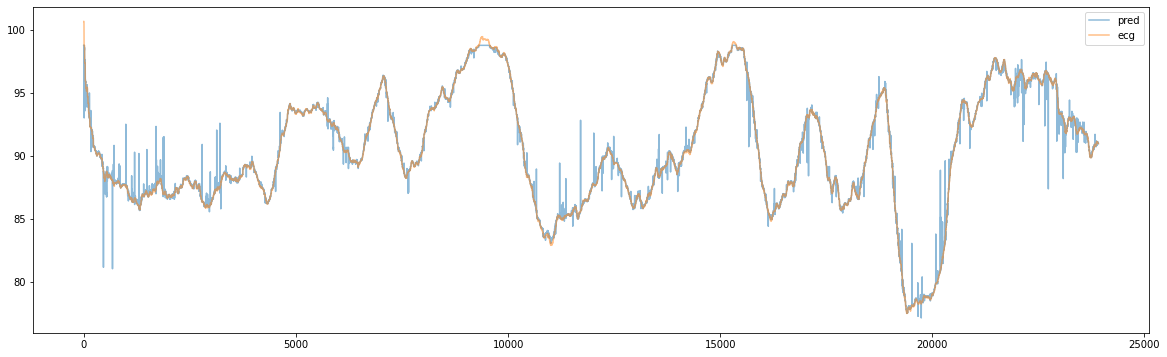

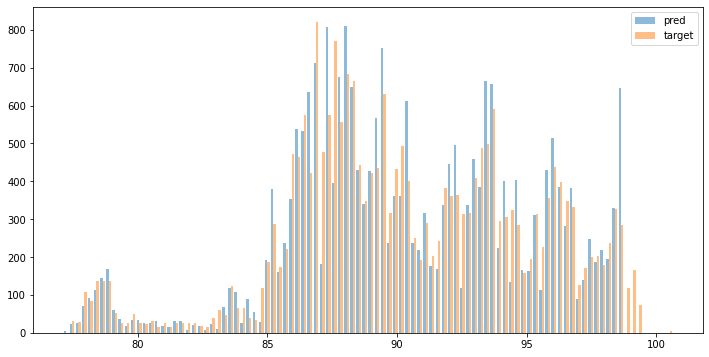

In [86]:
stacking_model('df0')

352/352 [==============================] - 2s 7ms/step - loss: 9.6564e-04 - mse: 9.6564e-04 - mae: 0.0234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20201111155643_ksj_0.5_lie_none.csv
MSE = 0.029
MAE = 0.0677
Error Rate = 0.0909


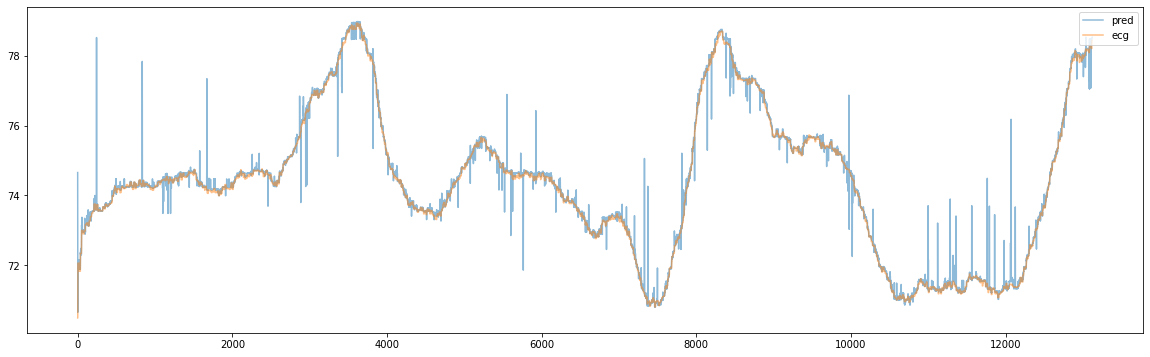

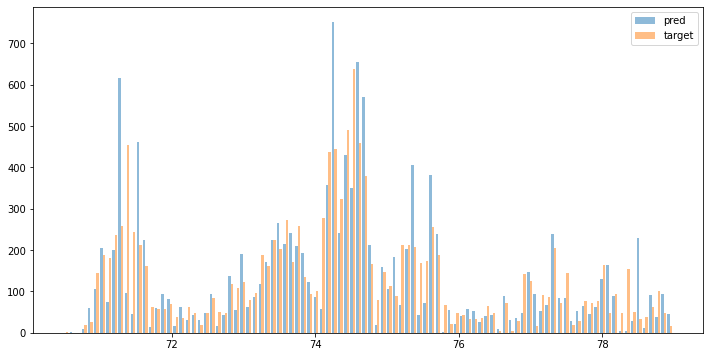

In [87]:
stacking_model('df1')

975/975 [==============================] - 7s 7ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0780


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210811104835_les_1.0_sleep.csv
MSE = 0.187
MAE = 0.1144
Error Rate = 0.183


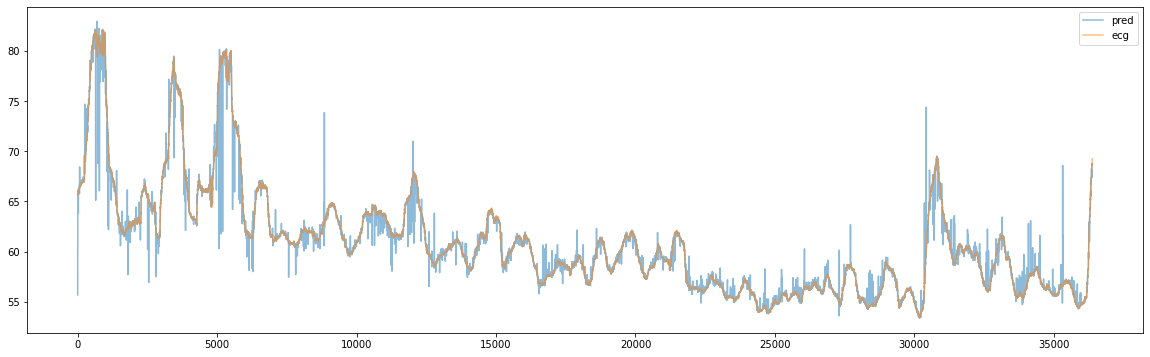

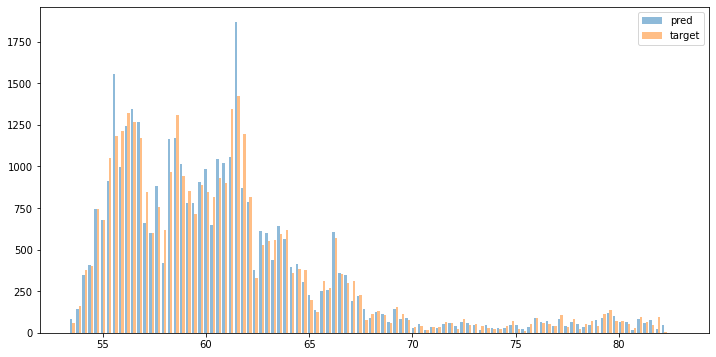

In [77]:
stacking_model('df2')

794/794 [==============================] - 5s 7ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.1015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:09:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210812111825_sjy_1.0_lie_none.csv
MSE = 0.1825
MAE = 0.1205
Error Rate = 0.223


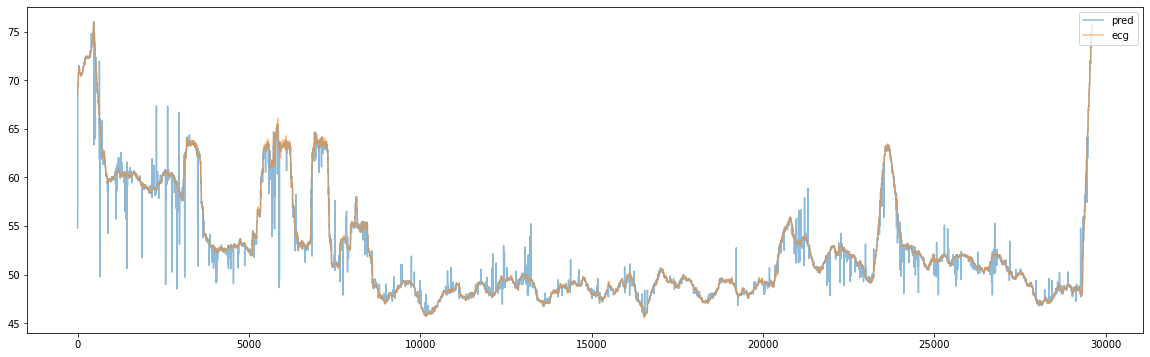

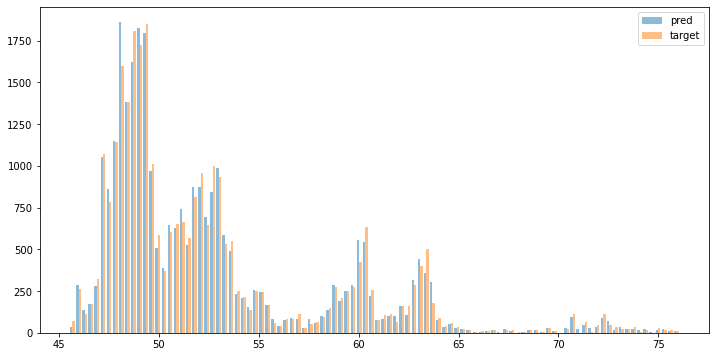

In [78]:
stacking_model('df3')

1137/1137 [==============================] - 7s 6ms/step - loss: 0.0444 - mse: 0.0444 - mae: 0.1528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:15:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:16:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:17:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210818153244_kdu_1.0_lie_none.csv
MSE = 0.5158
MAE = 0.1834
Error Rate = 0.3177


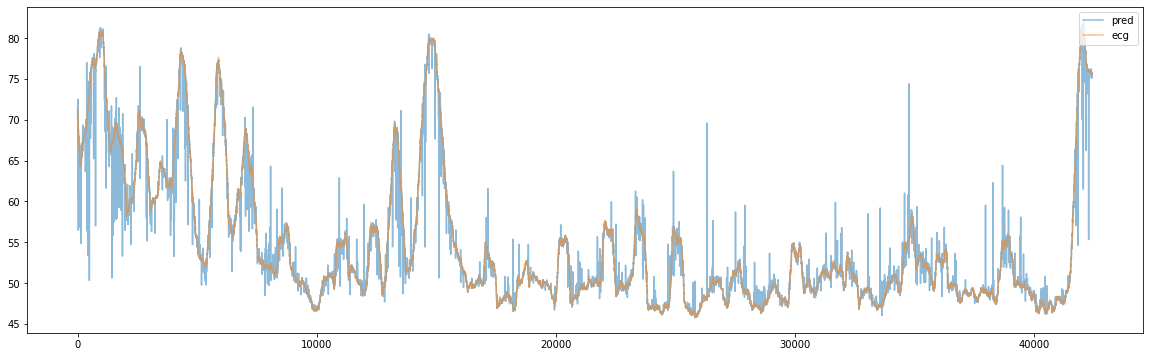

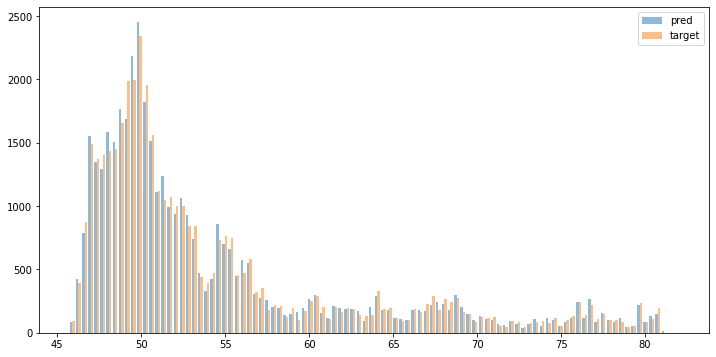

In [79]:
stacking_model('df4')

191/191 [==============================] - 1s 7ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:19:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210824111504_kdu_1.0_lie_none.csv
MSE = 0.0278
MAE = 0.0748
Error Rate = 0.1498


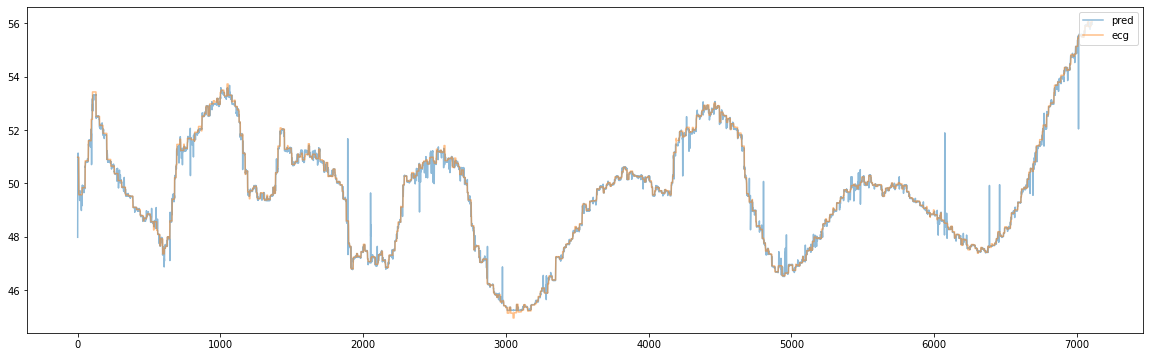

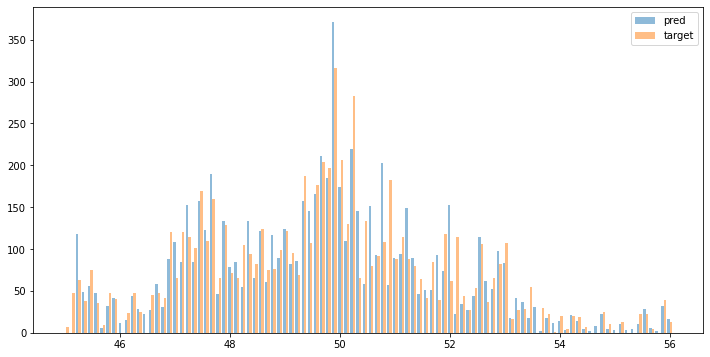

In [80]:
stacking_model('df5')

310/310 [==============================] - 2s 7ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:20:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210824121025_chc_0.5_lie_none.csv
MSE = 0.1409
MAE = 0.1193
Error Rate = 0.1513


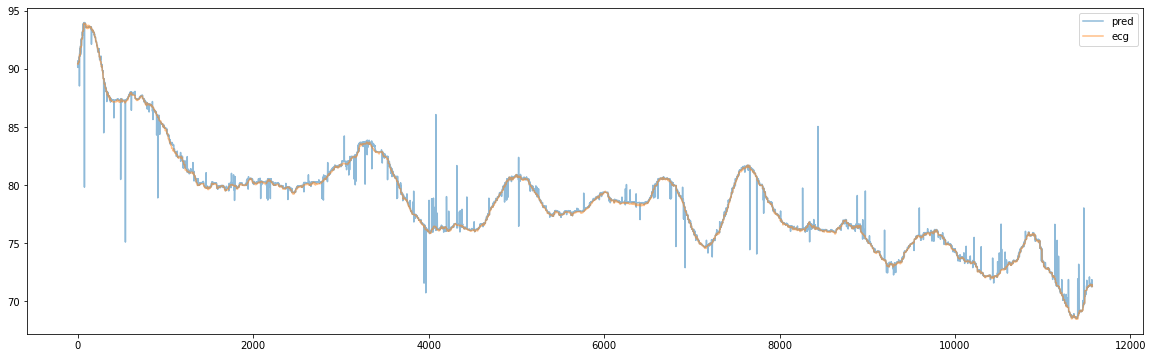

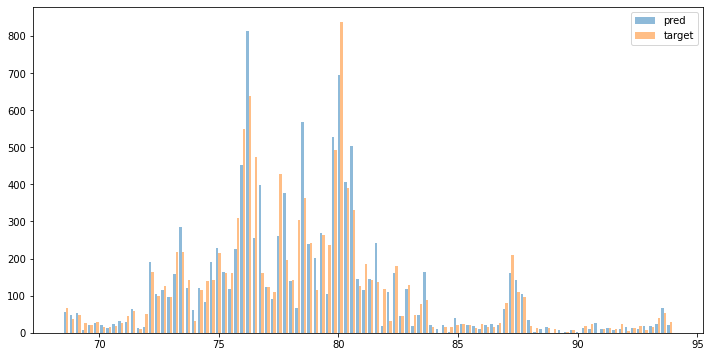

In [81]:
stacking_model('df6')

474/474 [==============================] - 3s 7ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0620


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:23:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:23:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210824141813_kdu_1.0_lie_acryl.csv
MSE = 0.2121
MAE = 0.1276
Error Rate = 0.1875


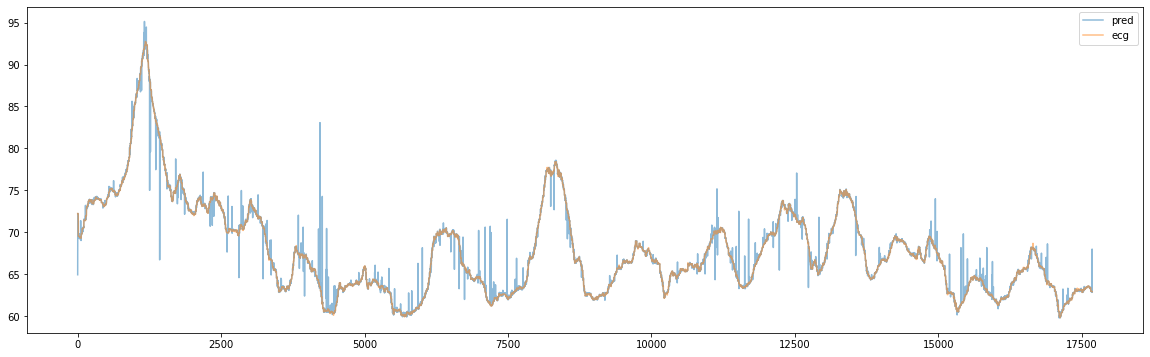

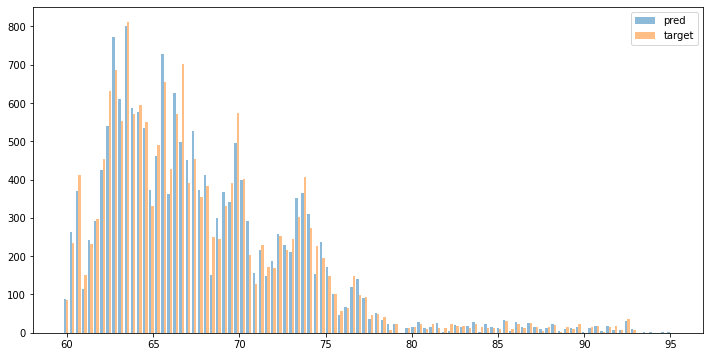

In [82]:
stacking_model('df7')

444/444 [==============================] - 3s 7ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:26:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210824141815_kdu_1.0_lie_opaque.csv
MSE = 0.1965
MAE = 0.1316
Error Rate = 0.1922


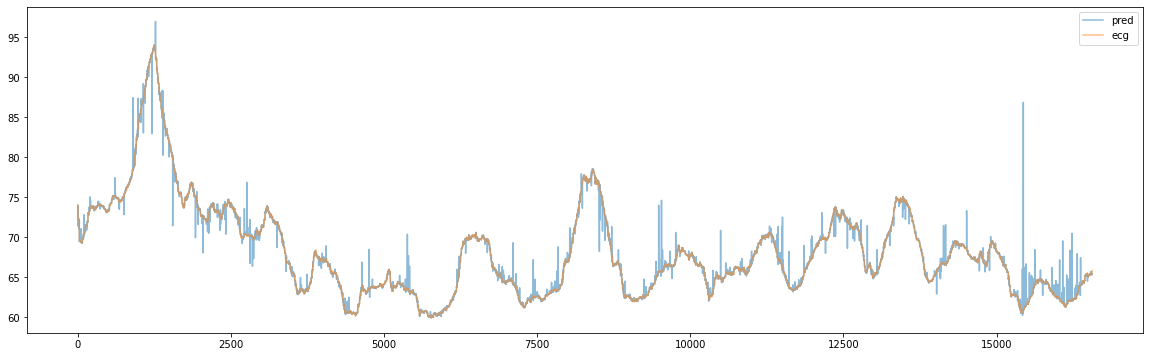

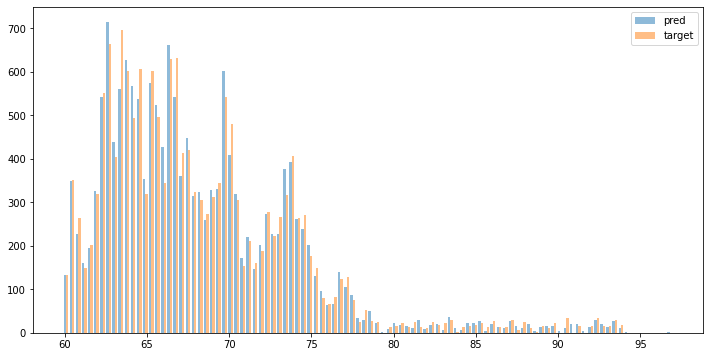

In [83]:
stacking_model('df8')

256/256 [==============================] - 2s 6ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210906175352_1.0_lie_gmk.csv
MSE = 0.3185
MAE = 0.2138
Error Rate = 0.2907


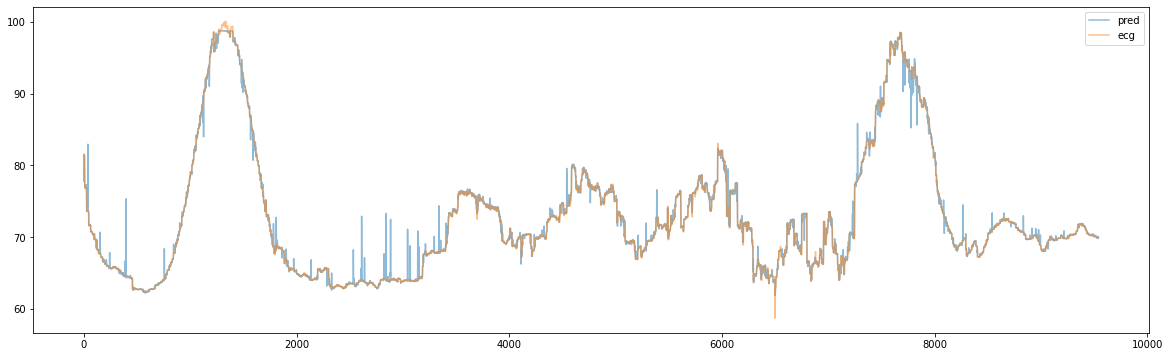

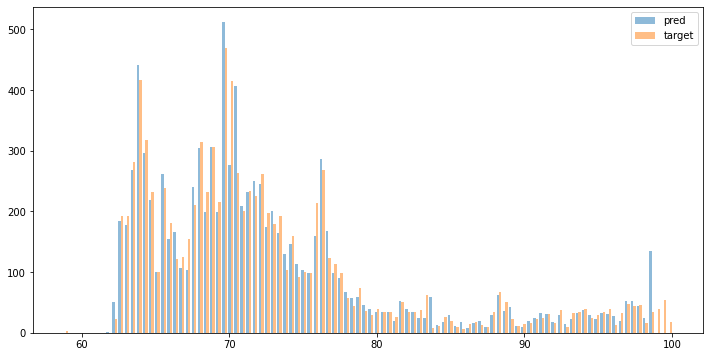

In [84]:
stacking_model('df9')

31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y wa

[09:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


/content/drive/MyDrive/와플 데이터/log_20210908142718_kdu_1.0_lie_acryl111.csv
MSE = 0.0869
MAE = 0.1631
Error Rate = 0.1982


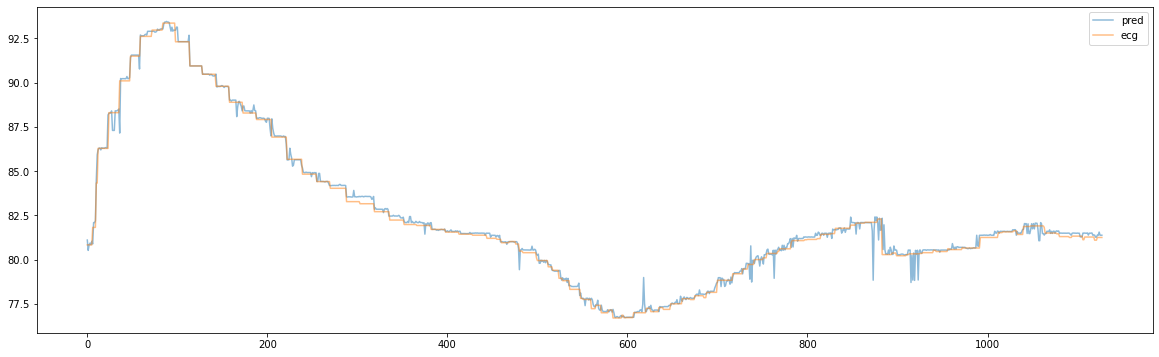

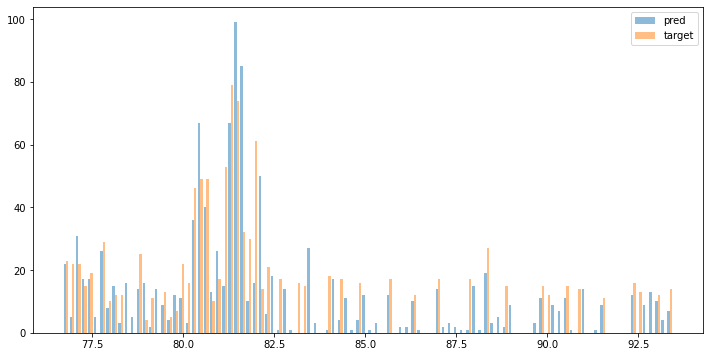

In [85]:
stacking_model('df10')

# 4) 결과

|  	|df0|df1|df2|df3|df4|df5|df6|df7|df8|df9|df10|
|---|---|---|---|---|---|---|---|---|---|---|---|
| MSE 	| 0.072 	| 0.029 	| 0.1870 	| 0.1825 	| 0.5158 	| 0.0278 	| 0.1409 	| 0.2121 	| 0.1965 	| 0.3185 	| 0.0869 	|
| MAE 	| 0.1028 	| 0.0677 	| 0.1144 	| 0.1205 	| 0.1834 	| 0.0748 	| 0.1193 	| 0.1276 	| 0.1316 	| 0.2138 	| 0.1631 	|
| Error Rate 	| 0.1143 	| 0.0909 	| 0.1830 	| 0.2230 	| 0.3177 	| 0.1498 	| 0.1513 	| 0.1875 	| 0.1922 	| 0.2907 	| 0.1982 	|

* 범용 모델로 전체 사람 11명의 에러율 1% 미만으로 예측